# unsafe.Pointer usage survey



In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import json
from datetime import datetime

In [3]:
MATCH_TYPES = (
    'unsafe.Pointer', 'unsafe.Sizeof', 'unsafe.Alignof', 'unsafe.Offsetof',
    'uintptr', 'reflect.SliceHeader', 'reflect.StringHeader'
)

Analysedauer der verschiedenen Analysen:

 - Download: ca. 4h
 - Grep: ca. 15min
 - Vet: ca. 2h 51min
 - Gosec: ca. 24h

## Analyse von Projektdaten

In [4]:
projects_df = pd.read_csv('/root/data/projects.csv',
                         parse_dates=['project_created_at', 'project_last_pushed_at', 'project_updated_at'])

In [5]:
projects_df[:5]

,project_name,project_rank,project_github_clone_url,project_number_of_stars,project_number_of_forks,project_github_id,project_created_at,project_last_pushed_at,project_updated_at,project_size,project_checkout_path
0,golang/go,1,https://github.com/golang/go.git,71418,10193,23096959,2014-08-19 04:33:40+00:00,2020-04-18 20:57:20+00:00,2020-04-18 20:08:52+00:00,210030,/root/download/go
1,kubernetes/kubernetes,2,https://github.com/kubernetes/kubernetes.git,65134,23200,20580498,2014-06-06 22:56:04+00:00,2020-04-18 20:02:41+00:00,2020-04-18 19:41:33+00:00,909658,/root/download/kubernetes
2,moby/moby,3,https://github.com/moby/moby.git,56855,16432,7691631,2013-01-18 18:10:57+00:00,2020-04-18 19:25:14+00:00,2020-04-18 20:33:23+00:00,153084,/root/download/moby
3,avelino/awesome-go,4,https://github.com/avelino/awesome-go.git,53568,7109,21540759,2014-07-06 13:42:15+00:00,2020-04-17 21:01:23+00:00,2020-04-18 20:28:01+00:00,8314,/root/download/awesome-go
4,gohugoio/hugo,5,https://github.com/gohugoio/hugo.git,43293,4916,11180687,2013-07-04 15:26:26+00:00,2020-04-18 12:16:44+00:00,2020-04-18 20:33:36+00:00,86028,/root/download/hugo


## Analyse von Grep Daten

In [6]:
grep_df = pd.read_csv('/root/data/grep_findings_0_499.csv')

In [7]:
grep_df

,text,context,line_number,column,absolute_offset,match_type,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
0,var CacheLineSize uintptr = CacheLinePadSize\n,\n// CacheLineSize is the CPU's assumed cache ...,20,18,769,uintptr,cpu.go,7184,245,internal/cpu,std,std,kubernetes/kubernetes,internal/cpu/cpu.go
1,\toffsetX86HasSSE2 = unsafe.Offsetof(cpu.X86...,)\n\n// Offsets into internal/cpu records for ...,14,22,281,unsafe.Offsetof,bytealg.go,664,23,internal/bytealg,std,std,kubernetes/kubernetes,internal/bytealg/bytealg.go
2,\toffsetX86HasSSE42 = unsafe.Offsetof(cpu.X86...,\n// Offsets into internal/cpu records for use...,15,22,336,unsafe.Offsetof,bytealg.go,664,23,internal/bytealg,std,std,kubernetes/kubernetes,internal/bytealg/bytealg.go
3,\toffsetX86HasAVX2 = unsafe.Offsetof(cpu.X86...,// Offsets into internal/cpu records for use i...,16,22,392,unsafe.Offsetof,bytealg.go,664,23,internal/bytealg,std,std,kubernetes/kubernetes,internal/bytealg/bytealg.go
4,\toffsetX86HasPOPCNT = unsafe.Offsetof(cpu.X86...,const (\n\toffsetX86HasSSE2 = unsafe.Offseto...,17,22,447,unsafe.Offsetof,bytealg.go,664,23,internal/bytealg,std,std,kubernetes/kubernetes,internal/bytealg/bytealg.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738988,\t\tm.hash = make(map[uintptr]*profMapEntry)\n,\tfor j := range stk {\n\t\te.stk[j] = uintptr...,79,20,1820,uintptr,map.go,1984,90,runtime/pprof,std,std,bosun-monitor/bosun,runtime/pprof/map.go
2738989,\tpcs [1]uintptr\n,\tmu sync.Mutex\n\t// file holds writer for ea...,442,8,12900,uintptr,glog.go,36393,1180,github.com/golang/glog,github.com/golang/glog,v0.0.0-20160126235308-23def4e6c14b,bosun-monitor/bosun,github.com/golang/glog/glog.go
2738990,\tvmap map[uintptr]Level\n,\t// pcs is used in V to avoid an allocation w...,445,10,13050,uintptr,glog.go,36393,1180,github.com/golang/glog,github.com/golang/glog,v0.0.0-20160126235308-23def4e6c14b,bosun-monitor/bosun,github.com/golang/glog/glog.go
2738991,\t\tlogging.vmap = make(map[uintptr]Level)\n,\n\t// Set the new filters and wipe the pc->Le...,478,26,14287,uintptr,glog.go,36393,1180,github.com/golang/glog,github.com/golang/glog,v0.0.0-20160126235308-23def4e6c14b,bosun-monitor/bosun,github.com/golang/glog/glog.go


In [8]:
# 10 examples of an unsafe.Pointer match

print("\n\n".join([s.strip() for s in list(grep_df['text'][:10])]))

var CacheLineSize uintptr = CacheLinePadSize

offsetX86HasSSE2   = unsafe.Offsetof(cpu.X86.HasSSE2)

offsetX86HasSSE42  = unsafe.Offsetof(cpu.X86.HasSSE42)

offsetX86HasAVX2   = unsafe.Offsetof(cpu.X86.HasAVX2)

offsetX86HasPOPCNT = unsafe.Offsetof(cpu.X86.HasPOPCNT)

offsetS390xHasVX = unsafe.Offsetof(cpu.S390X.HasVX)

func Loadp(ptr unsafe.Pointer) unsafe.Pointer {

func Loadp(ptr unsafe.Pointer) unsafe.Pointer {

return *(*unsafe.Pointer)(ptr)

func Xadduintptr(ptr *uintptr, delta uintptr) uintptr


In [9]:
# 1 example of a match context

print(grep_df['context'][0])


// CacheLineSize is the CPU's assumed cache line size.
// There is currently no runtime detection of the real cache line size
// so we use the constant per GOARCH CacheLinePadSize as an approximation.
var CacheLineSize uintptr = CacheLinePadSize

var X86 x86

// The booleans in x86 contain the correspondingly named cpuid feature bit.
// HasAVX and HasAVX2 are only set if the OS does support XMM and YMM registers



## Analyse von Package Daten

In [10]:
package_df = pd.read_csv('/root/data/packages_0_499.csv')

In [11]:
package_df

,name,import_path,dir,is_standard,is_dep_only,number_of_go_files,loc,byte_size,module_path,module_version,module_registry,module_is_indirect,project_name
0,gci,k8s.io/kubernetes/cluster/gce/gci,/root/download/kubernetes/cluster/gce/gci,False,False,0,0,0,k8s.io/kubernetes,NaN,k8s.io,False,kubernetes/kubernetes
1,cpu,internal/cpu,/usr/local/go/src/internal/cpu,True,True,3,357,10131,std,std,std,False,kubernetes/kubernetes
2,unsafe,unsafe,/usr/local/go/src/unsafe,True,True,1,205,9215,std,std,std,False,kubernetes/kubernetes
3,bytealg,internal/bytealg,/usr/local/go/src/internal/bytealg,True,True,8,172,4841,std,std,std,False,kubernetes/kubernetes
4,atomic,runtime/internal/atomic,/usr/local/go/src/runtime/internal/atomic,True,True,2,127,2571,std,std,std,False,kubernetes/kubernetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144415,main,bosun.org/cmd/scollector,/root/download/bosun/cmd/scollector,False,False,3,1071,32951,bosun.org,NaN,std,False,bosun-monitor/bosun
144416,main,bosun.org/cmd/silence,/root/download/bosun/cmd/silence,False,False,1,125,3076,bosun.org,NaN,std,False,bosun-monitor/bosun
144417,main,bosun.org/cmd/snmpTester,/root/download/bosun/cmd/snmpTester,False,False,2,320,7882,bosun.org,NaN,std,False,bosun-monitor/bosun
144418,main,bosun.org/cmd/tsdbrelay,/root/download/bosun/cmd/tsdbrelay,False,False,2,468,15239,bosun.org,NaN,std,False,bosun-monitor/bosun


## Analyse von Go Vet Daten

In [394]:
vet_df = pd.read_csv('/root/data/vet_findings_0_499.csv')

In [395]:
vet_df.dtypes

message                object
context                object
line_number             int64
column                  int64
raw_output             object
file_name              object
file_loc                int64
file_byte_size          int64
package_import_path    object
module_path            object
module_version         object
project_name           object
file_copy_path         object
dtype: object

In [396]:
vet_df

,message,context,line_number,column,raw_output,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
0,possible misuse of unsafe.Pointer,"\t\t\tif !CompareAndSwapPointer(&vp.typ, nil, ...",59,44,/usr/local/go/src/sync/atomic/value.go:59:44: ...,value.go,86,2446,sync/atomic,std,std,kubernetes/kubernetes,sync/atomic/value.go
1,possible misuse of unsafe.Pointer,\treturn unsafe.Pointer(x ^ 0),287,9,/root/go/pkg/mod/github.com/modern-go/reflect2...,reflect2.go,298,7272,github.com/modern-go/reflect2,github.com/modern-go/reflect2,v1.0.1,kubernetes/kubernetes,github.com/modern-go/reflect2/reflect2.go
2,possible misuse of unsafe.Pointer,\treturn unsafe.Pointer(x ^ 0),30,9,/usr/local/go/src/strings/builder.go:30:9: pos...,builder.go,125,3562,strings,std,std,kubernetes/kubernetes,strings/builder.go
3,possible misuse of unsafe.Pointer,\tsize := *(*uintptr)(unsafe.Pointer(ptr + uns...,56,22,/usr/local/go/src/runtime/alg.go:56:22: possib...,alg.go,389,10428,runtime,std,std,kubernetes/kubernetes,runtime/alg.go
4,possible misuse of unsafe.Pointer,\told := unsafe.Pointer(sync_atomic_SwapUintpt...,63,9,/usr/local/go/src/runtime/atomic_pointer.go:63...,atomic_pointer.go,77,2683,runtime,std,std,kubernetes/kubernetes,runtime/atomic_pointer.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110262,struct field tag `json,"\tCycle string `json:""cycle:`",93,2,/root/go/pkg/mod/github.com/kylebrandt/gohop@v...,gohop.go,371,9778,github.com/kylebrandt/gohop,github.com/kylebrandt/gohop,v0.0.0-20160712175359-f6dbeb38f6df,bosun-monitor/bosun,github.com/kylebrandt/gohop/gohop.go
110263,golang.org/x/oauth2/internal.ErrorTransport co...,\t\t\treturn &http.Client{Transport: internal....,298,35,/root/go/pkg/mod/golang.org/x/oauth2@v0.0.0-20...,oauth2.go,337,11230,golang.org/x/oauth2,golang.org/x/oauth2,v0.0.0-20160608215109-65a8d08c6292,bosun-monitor/bosun,golang.org/x/oauth2/oauth2.go
110264,unreachable code,"\tpanic(""unreachable"")",121,2,/root/go/pkg/mod/gopkg.in/yaml.v1@v1.0.0-20140...,decode.go,566,12779,gopkg.in/yaml.v1,gopkg.in/yaml.v1,v1.0.0-20140924161607-9f9df34309c0,bosun-monitor/bosun,gopkg.in/yaml.v1/decode.go
110265,unreachable code,\treturn false,669,2,/root/go/pkg/mod/gopkg.in/yaml.v1@v1.0.0-20140...,emitterc.go,1685,45308,gopkg.in/yaml.v1,gopkg.in/yaml.v1,v1.0.0-20140924161607-9f9df34309c0,bosun-monitor/bosun,gopkg.in/yaml.v1/emitterc.go


## Analyse von Gosec Daten

In [398]:
gosec_df = pd.read_csv('/root/data/gosec_findings_0_499.csv')

In [399]:
gosec_df

,message,context,confidence,severity,cwe_id,rule_id,line_number,column,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
0,Use of weak random number generator (math/rand...,rand.Int(),MEDIUM,HIGH,338.0,G404,392,43,pd.go,654,26896,k8s.io/kubernetes/test/e2e/storage,k8s.io/kubernetes,NaN,kubernetes/kubernetes,k8s.io/kubernetes/test/e2e/storage/pd.go
1,Use of weak random number generator (math/rand...,rand.Int(),MEDIUM,HIGH,338.0,G404,50,14,dnsclient_unix.go,790,22389,net,std,std,kubernetes/kubernetes,net/dnsclient_unix.go
2,Potential hardcoded credentials,"repeatedStringForImagePullSecrets := ""[]LocalO...",LOW,HIGH,798.0,G101,25728,2,generated.pb.go,66605,1656252,k8s.io/api/core/v1,k8s.io/api,v0.0.0,kubernetes/kubernetes,k8s.io/api/core/v1/generated.pb.go
3,Potential hardcoded credentials,"repeatedStringForSecrets := ""[]ObjectReference{""",LOW,HIGH,798.0,G101,26507,2,generated.pb.go,66605,1656252,k8s.io/api/core/v1,k8s.io/api,v0.0.0,kubernetes/kubernetes,k8s.io/api/core/v1/generated.pb.go
4,Potential hardcoded credentials,"secretVal = ""086a7ffc-0225-11e8...",LOW,HIGH,798.0,G101,49,2,transformation_testcase.go,262,8290,k8s.io/kubernetes/test/integration/master,k8s.io/kubernetes,NaN,kubernetes/kubernetes,k8s.io/kubernetes/test/integration/master/tran...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432342,Errors unhandled.,"io.CopyN(ioutil.Discard, resp.Body, 512)",HIGH,LOW,703.0,G104,396,5,main.go,425,12726,bosun.org/cmd/tsdbrelay,bosun.org,NaN,bosun-monitor/bosun,bosun.org/cmd/tsdbrelay/main.go
1432343,Errors unhandled.,resp.Body.Close(),HIGH,LOW,703.0,G104,397,5,main.go,425,12726,bosun.org/cmd/tsdbrelay,bosun.org,NaN,bosun-monitor/bosun,bosun.org/cmd/tsdbrelay/main.go
1432344,Errors unhandled.,"http.Post(""http://localhost:5555/api/metadata/...",HIGH,LOW,703.0,G104,144,2,main.go,221,5719,bosun.org/cmd/tsdbrelay/integrationTest,bosun.org,NaN,bosun-monitor/bosun,bosun.org/cmd/tsdbrelay/integrationTest/main.go
1432345,Errors unhandled.,jw.Encode(mdp),HIGH,LOW,703.0,G104,212,2,main.go,221,5719,bosun.org/cmd/tsdbrelay/integrationTest,bosun.org,NaN,bosun-monitor/bosun,bosun.org/cmd/tsdbrelay/integrationTest/main.go


# Auswertungen

## Wie viele Datenpunkte sind vorhanden?

In [400]:
print("Anzahl Projekte (Metadaten): {:,}".format(projects_df['project_name'].count()))
print("Anzahl Projekte (analysiert): {:,}".format(package_df['project_name'].nunique()))
print("Anzahl analysierter Packages: {:,}".format(package_df['import_path'].nunique()))
print("Anzahl analysierter Module: {:,}".format(package_df['module_path'].nunique()))
print("Anzahl Datenpunkte Grep: {:,}".format(grep_df['text'].count()))
print("Anzahl Datenpunkte Vet: {:,}".format(vet_df['line_number'].count()))
print("Anzahl Datenpunkte Gosec: {:,}".format(gosec_df['line_number'].count()))

Anzahl Projekte (Metadaten): 500
Anzahl Projekte (analysiert): 481
Anzahl analysierter Packages: 37,482
Anzahl analysierter Module: 3,119
Anzahl Datenpunkte Grep: 2,738,993
Anzahl Datenpunkte Vet: 110,267
Anzahl Datenpunkte Gosec: 1,432,347


In [296]:
print("Anzahl tatsächlich verschiedener Zeilen mit unsafe usages: {:,}".format(grep_df['text'].nunique()))

Anzahl tatsächlich verschiedener Zeilen mit unsafe usages: 12,259


## Anzahl von unsafe usages nach Projekt

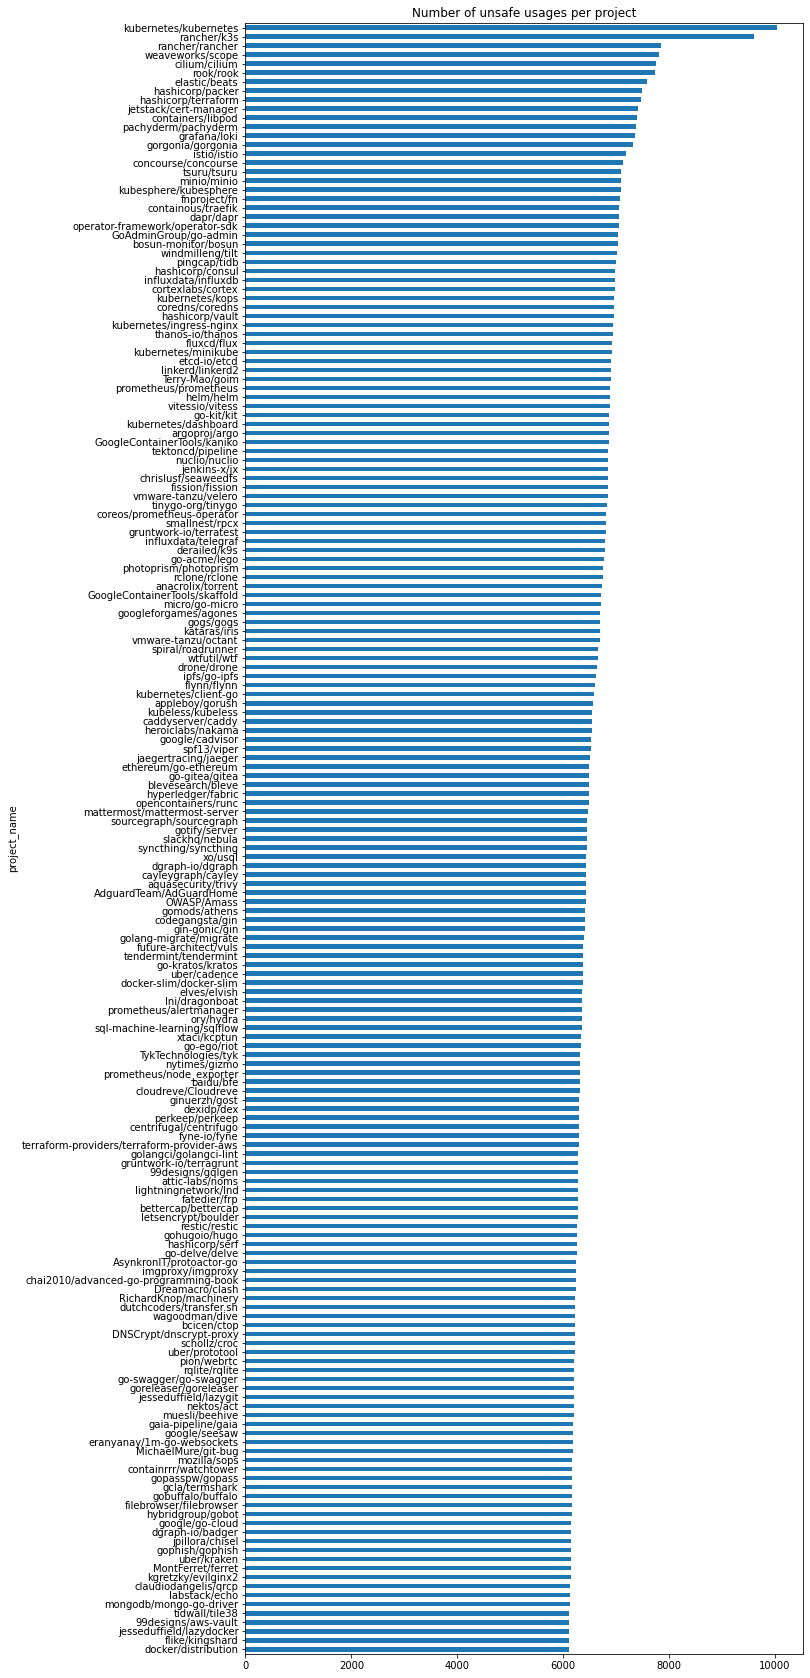

In [367]:
grep_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True)[300:]\
    .plot.barh(title='Number of unsafe usages per project', figsize=(10, 30))

## Anzahl von unsafe usages nach Modul

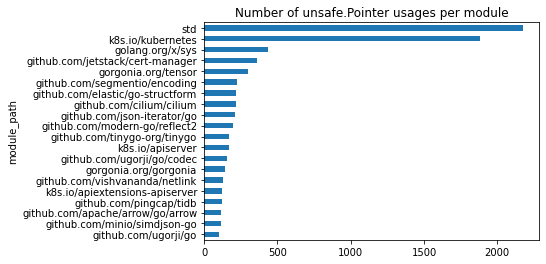

In [21]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of unsafe.Pointer usages per module')

In [22]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=False)[:15]

module_path
std                                 2176
k8s.io/kubernetes                   1881
golang.org/x/sys                     436
github.com/jetstack/cert-manager     358
gorgonia.org/tensor                  299
github.com/segmentio/encoding        223
github.com/elastic/go-structform     220
github.com/cilium/cilium             218
github.com/json-iterator/go          213
github.com/modern-go/reflect2        194
github.com/tinygo-org/tinygo         172
k8s.io/apiserver                     168
github.com/ugorji/go/codec           157
gorgonia.org/gorgonia                144
github.com/vishvananda/netlink       131
Name: module_path, dtype: int64

Wir sehen einen unglaublich großen Vorsprung der Standardlibrary mit ihren Packages. Danach scheint kubernetes einen vergleichsweise extremen Vorsprung zu haben, und das "gefährlichste" Module ist `sys`.

## Anzahl von unsafe Usages nach Package

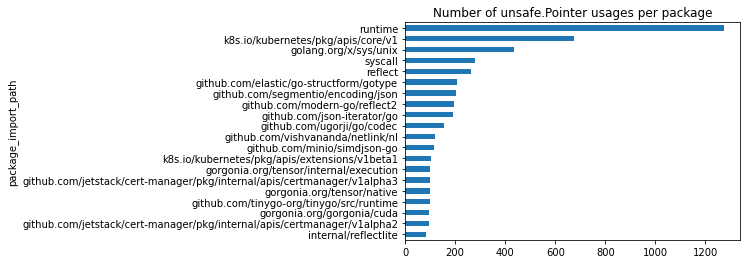

In [23]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .groupby(['package_import_path', 'project_name'])['package_import_path'].count()\
    .groupby('package_import_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of unsafe.Pointer usages per package')

## Anzahl von unsafe.Pointer usages pro Registry

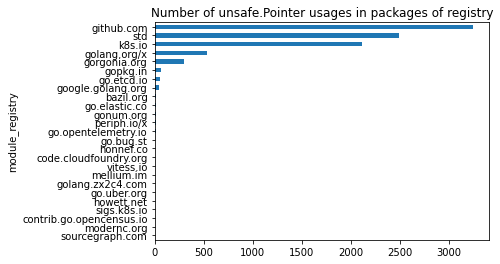

In [32]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .dropna()

df2 = package_df

mdf = pd.merge(df1, df2, how='left', 
         left_on=['project_name', 'package_import_path', 'module_path', 'module_version'], 
         right_on=['project_name', 'import_path', 'module_path', 'module_version'])

mdf\
    .groupby(['module_registry', 'package_import_path', 'project_name'])['module_registry'].count()\
    .groupby(['module_registry', 'package_import_path']).max()\
    .groupby('module_registry').sum()\
    .sort_values(ascending=True)\
    .plot.barh(title='Number of unsafe.Pointer usages in packages of registry')

In [34]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .dropna()

df2 = package_df

mdf = pd.merge(df1, df2, how='left', 
         left_on=['project_name', 'package_import_path', 'module_path', 'module_version'], 
         right_on=['project_name', 'import_path', 'module_path', 'module_version'])

mdf\
    .groupby(['module_registry', 'package_import_path', 'project_name'])['module_registry'].count()\
    .groupby(['module_registry', 'package_import_path']).max()\
    .groupby('module_registry').sum()\
    .sort_values(ascending=False)

module_registry
github.com                  3253
std                         2490
k8s.io                      2114
golang.org/x                 532
gorgonia.org                 299
gopkg.in                      61
go.etcd.io                    56
google.golang.org             41
bazil.org                     12
go.elastic.co                 11
gonum.org                     10
periph.io/x                   10
go.opentelemetry.io           10
go.bug.st                      8
honnef.co                      7
code.cloudfoundry.org          7
vitess.io                      7
mellium.im                     6
golang.zx2c4.com               6
go.uber.org                    3
howett.net                     2
sigs.k8s.io                    2
contrib.go.opencensus.io       2
modernc.org                    1
sourcegraph.com                1
Name: module_registry, dtype: int64

Wir sehen, dass die meisten unsafe usages in `github.com` zu finden sind, sogar noch mehr als in der Standardbibliothek. Das wird aber vermutlich einfach dadurch erzeugt, dass in dieser Registry auch die meisten Packages zu finden sind:

## Anzahl Packages pro Registry

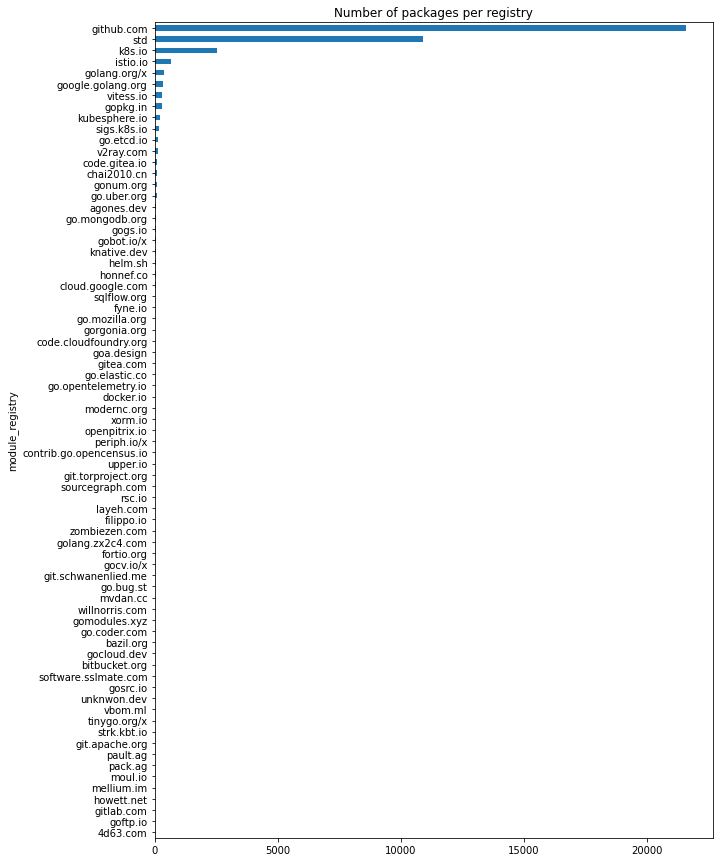

In [128]:
package_df\
    .groupby('module_registry')['import_path'].nunique()\
    .sort_values(ascending=True)\
    .plot.barh(title='Number of packages per registry', figsize=(10,15))

In [127]:
package_df\
    .groupby('module_registry')['import_path'].nunique()\
    .sort_values(ascending=False)

module_registry
github.com      21587
std             10888
k8s.io           2546
istio.io          684
golang.org/x      378
                ...  
mellium.im          1
howett.net          1
gitlab.com          1
goftp.io            1
4d63.com            1
Name: import_path, Length: 73, dtype: int64

## Unterschiedliche Anzahl von unsafe.Pointer usages im gleichen Modul

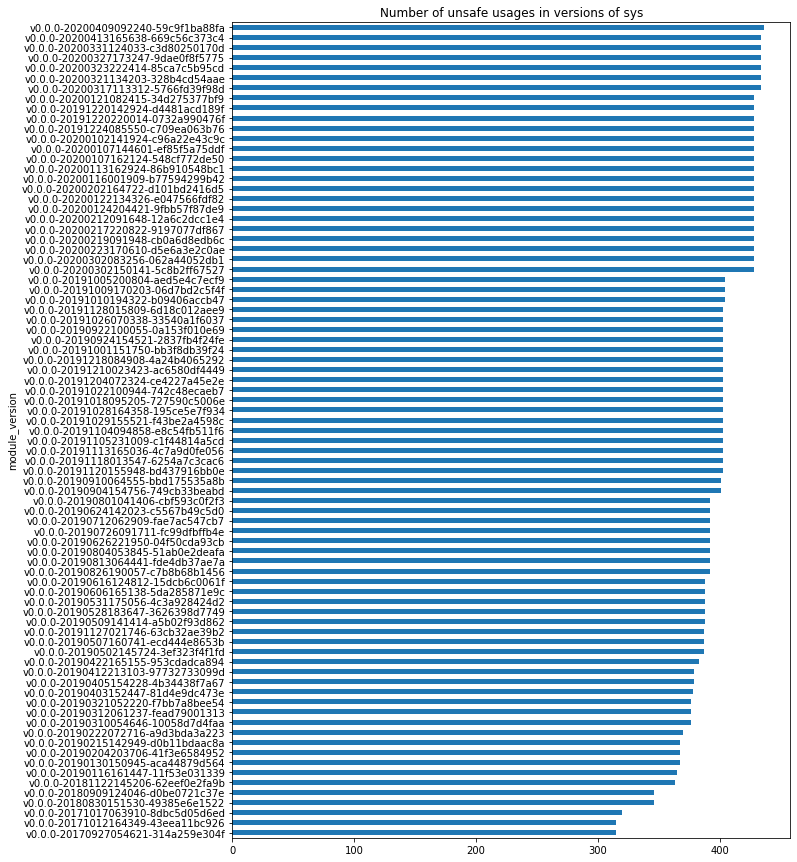

In [48]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .where(grep_df['module_path']=='golang.org/x/sys')\
    .groupby(['module_version', 'project_name'])['module_version'].count()\
    .groupby('module_version').max()\
    .sort_values(ascending=True)\
    .plot.barh(title='Number of unsafe usages in versions of sys', figsize=(10,15))

In [49]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .where(grep_df['module_path']=='golang.org/x/sys')\
    .groupby(['module_version', 'project_name'])['module_version'].count()\
    .groupby('module_version').max()\
    .sort_values(ascending=False)

module_version
v0.0.0-20200409092240-59c9f1ba88fa    436
v0.0.0-20200413165638-669c56c373c4    434
v0.0.0-20200331124033-c3d80250170d    434
v0.0.0-20200327173247-9dae0f8f5775    434
v0.0.0-20200323222414-85ca7c5b95cd    434
                                     ... 
v0.0.0-20180909124046-d0be0721c37e    346
v0.0.0-20180830151530-49385e6e1522    346
v0.0.0-20171017063910-8dbc5d05d6ed    320
v0.0.0-20171012164349-43eea11bc926    315
v0.0.0-20170927054621-314a259e304f    315
Name: module_version, Length: 81, dtype: int64

Wir sehen, dass die verschiedenen Versionen zwischen 300 und 400 Usages haben. **Die Anzahl nimmt über die Zeit zu, die wenigsten Usages haben die Versionen von 2017, ganz oben stehen Versionen von 2020.**

Es ist schwierig einen Changelog für das Modul zu finden (es gibt keinen), man kann sich nur die Commits anschauen. Von der zweitneusten Version (59c9f1ba88fa) zur neusten (669c56c373c4) wird z.B. der Syscall `openat2` entfernt, der vorher hinzugekommen ist.

https://github.com/golang/sys/compare/59c9f1b...669c56c

Zwischen 8dbc5d05d6ed und 49385e6e1522 (+26 Vorkommnisse) sind einige nicht-syscall-bezogene Änderungen durchgeführt worden, aber aus den Commits ist nicht direkt ersichtlich was genau dort nun hinzugefügt wurde.

https://github.com/golang/sys/compare/8dbc5d05d6ed...49385e6e1522

## Anzahl von unsafe.Pointer usages pro Datei

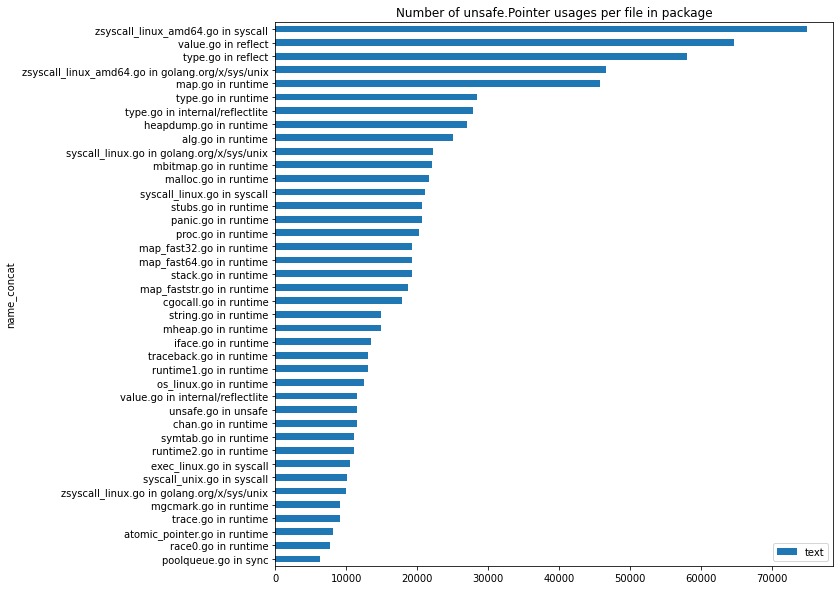

In [52]:
df = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .groupby(['file_name', 'package_import_path'], as_index=False)\
    ['text'].count()

df['name_concat'] = df.apply(lambda x: "{} in {}"\
                             .format(x['file_name'], x['package_import_path']), \
                             axis=1)

df\
    .iloc[:,[3,2]]\
    .sort_values(by='text', ascending=True)[-40:]\
    .plot.barh(x='name_concat', title='Number of unsafe.Pointer usages per file in package', figsize=(10,10))

Der Plot ist durch `sys` verzerrt, daher hier die Analyse ohne `sys`:

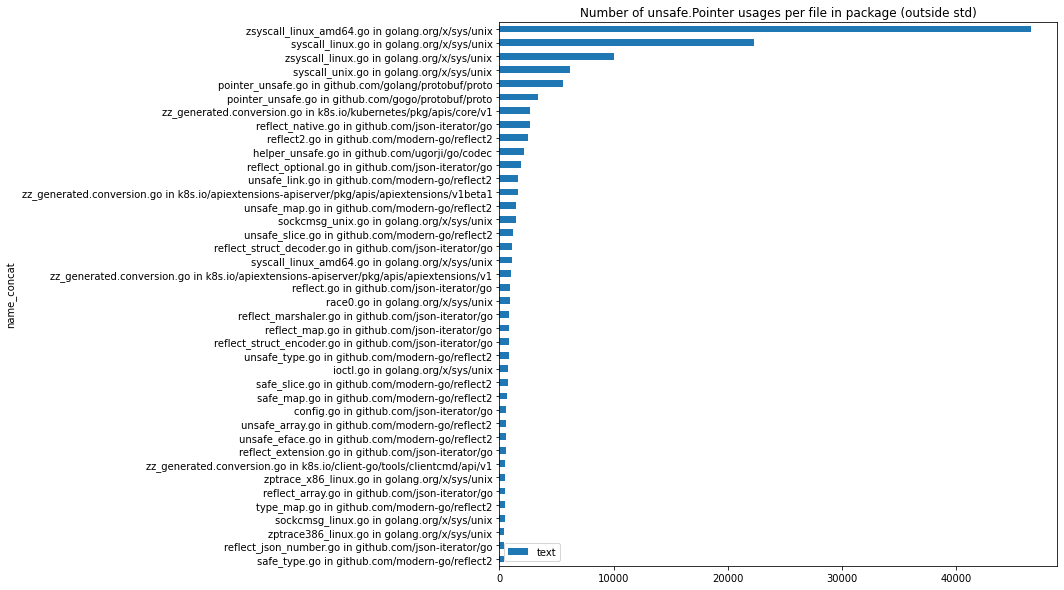

In [57]:
df = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .where(grep_df['module_path']!='std')\
    .groupby(['file_name', 'package_import_path'], as_index=False)\
    ['text'].count()

df['name_concat'] = df.apply(lambda x: "{} in {}"\
                             .format(x['file_name'], x['package_import_path']), \
                             axis=1)

df\
    .iloc[:,[3,2]]\
    .sort_values(by='text', ascending=True)[-40:]\
    .plot.barh(x='name_concat', title='Number of unsafe.Pointer usages per file in package (outside std)', figsize=(10,10))

In [59]:
df = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .where(grep_df['module_path']!='std')\
    .groupby(['file_name', 'package_import_path'], as_index=False)\
    ['text'].count()

df['name_concat'] = df.apply(lambda x: "{} in {}"\
                             .format(x['file_name'], x['package_import_path']), \
                             axis=1)

df\
    .iloc[:,[3,2]]\
    .sort_values(by='text', ascending=False)[:-20]

,name_concat,text
936,zsyscall_linux_amd64.go in golang.org/x/sys/unix,46519
744,syscall_linux.go in golang.org/x/sys/unix,22264
935,zsyscall_linux.go in golang.org/x/sys/unix,10000
746,syscall_unix.go in golang.org/x/sys/unix,6137
556,pointer_unsafe.go in github.com/golang/protobu...,5525
...,...,...
892,utmp_c.go in github.com/elastic/beats/v7/x-pac...,1
478,mod-check-default.go in github.com/vugu/vugu,1
479,moduledata.go in github.com/go-delve/delve/pkg...,1
867,util.go in github.com/apache/arrow/go/arrow/me...,1


## Wie oft werden Module importiert? (Beliebtheit)

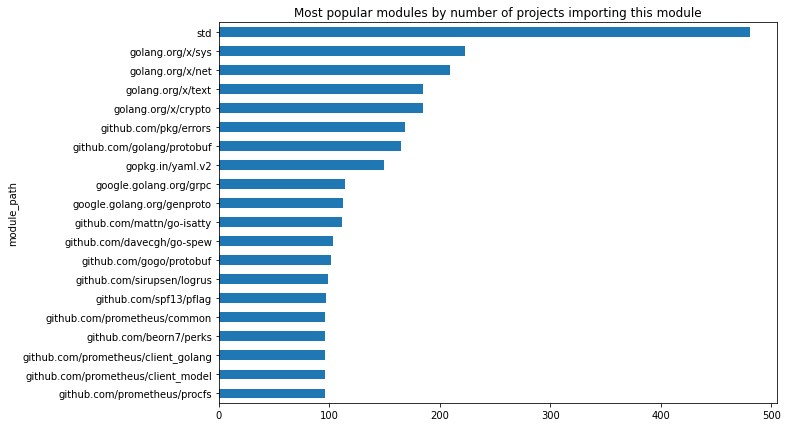

In [139]:
package_df\
    .groupby(['module_path'])['project_name'].nunique()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Most popular modules by number of projects importing this module', figsize=(10,7))

In [138]:
package_df\
    .groupby(['module_path'])['project_name'].nunique()\
    .sort_values(ascending=False)[:20]

module_path
std                                    481
golang.org/x/sys                       223
golang.org/x/net                       209
golang.org/x/text                      185
golang.org/x/crypto                    185
github.com/pkg/errors                  168
github.com/golang/protobuf             165
gopkg.in/yaml.v2                       149
google.golang.org/grpc                 114
google.golang.org/genproto             112
github.com/mattn/go-isatty             111
github.com/davecgh/go-spew             103
github.com/gogo/protobuf               101
github.com/sirupsen/logrus              99
github.com/spf13/pflag                  97
github.com/prometheus/common            96
github.com/beorn7/perks                 96
github.com/prometheus/client_golang     96
github.com/prometheus/client_model      96
github.com/prometheus/procfs            96
Name: project_name, dtype: int64

## Wie viele Module importieren die Projekte jeweils?

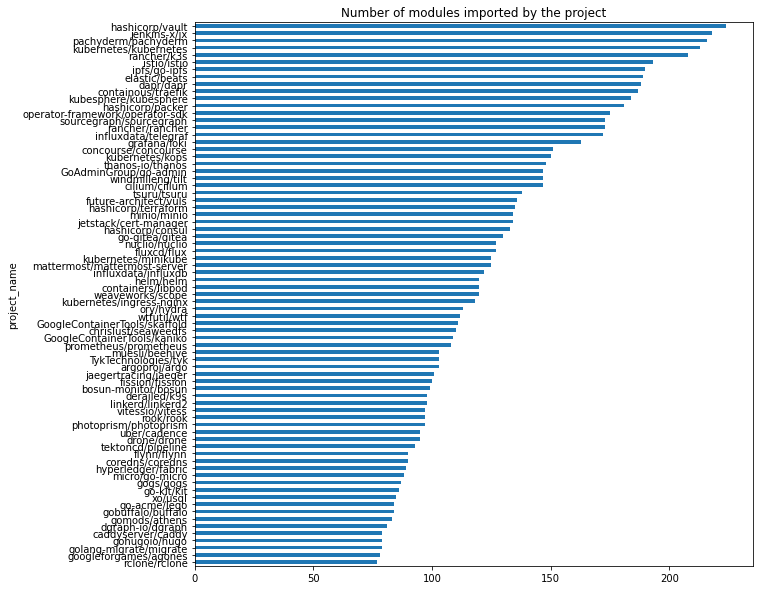

In [142]:
package_df\
    .groupby('project_name')['module_path'].nunique()\
    .sort_values(ascending=True)[-75:]\
    .plot.barh(title='Number of modules imported by the project', figsize=(10,10))

In [141]:
package_df\
    .groupby('project_name')['module_path'].nunique()\
    .sort_values(ascending=False)

project_name
hashicorp/vault          224
jenkins-x/jx             218
pachyderm/pachyderm      216
kubernetes/kubernetes    213
rancher/k3s              208
                        ... 
openfaas/faas              1
davecgh/go-spew            1
hashicorp/nomad            1
cyfdecyf/cow               1
hasura/gitkube             1
Name: module_path, Length: 481, dtype: int64

## Wie viele Packages importieren die Projekte jeweils?

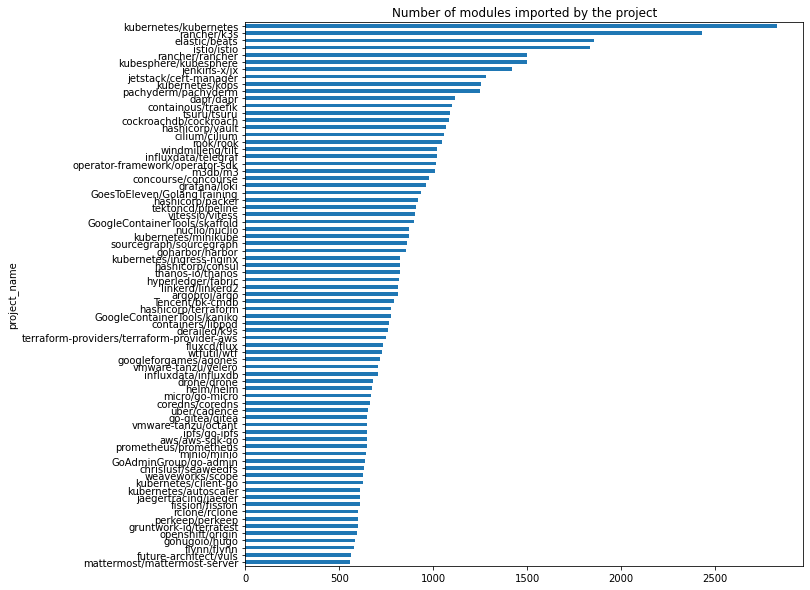

In [145]:
package_df\
    .groupby('project_name')['import_path'].nunique()\
    .sort_values(ascending=True)[-75:]\
    .plot.barh(title='Number of modules imported by the project', figsize=(10,10))

In [143]:
package_df\
    .groupby('project_name')['import_path'].nunique()\
    .sort_values(ascending=False)

project_name
kubernetes/kubernetes                 2829
rancher/k3s                           2428
elastic/beats                         1857
istio/istio                           1836
rancher/rancher                       1499
                                      ... 
buger/jsonparser                        32
astaxie/go-best-practice                31
unknwon/go-fundamental-programming      31
andlabs/ui                              28
jroimartin/gocui                        22
Name: import_path, Length: 481, dtype: int64

## Welche Module haben die meisten Packages?

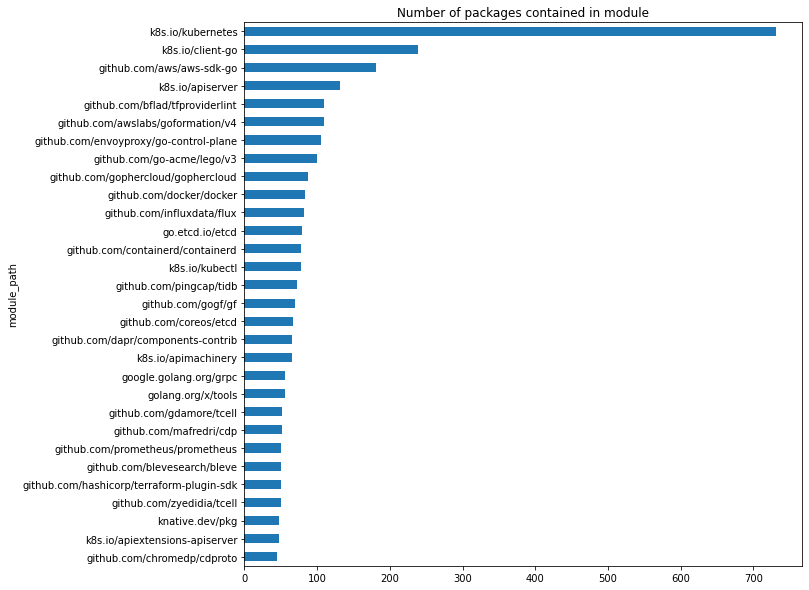

In [151]:
package_df\
    .where(package_df['module_path']!='std')\
    .groupby(['module_path', 'module_version'])['import_path'].nunique()\
    .groupby('module_path').max()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of packages contained in module (excluding std)', figsize=(10,10))

In [152]:
package_df\
    .where(package_df['module_path']!='std')\
    .groupby(['module_path', 'module_version'])['import_path'].nunique()\
    .groupby('module_path').max()\
    .sort_values(ascending=False)[:30]

module_path
k8s.io/kubernetes                            731
k8s.io/client-go                             239
github.com/aws/aws-sdk-go                    181
k8s.io/apiserver                             131
github.com/bflad/tfproviderlint              110
github.com/awslabs/goformation/v4            110
github.com/envoyproxy/go-control-plane       105
github.com/go-acme/lego/v3                   100
github.com/gophercloud/gophercloud            88
github.com/docker/docker                      83
github.com/influxdata/flux                    82
go.etcd.io/etcd                               79
github.com/containerd/containerd              78
k8s.io/kubectl                                78
github.com/pingcap/tidb                       72
github.com/gogf/gf                            70
github.com/coreos/etcd                        67
github.com/dapr/components-contrib            65
k8s.io/apimachinery                           65
google.golang.org/grpc                        56
golang.o

## Anzahl von Modulen und Packages pro Projekt

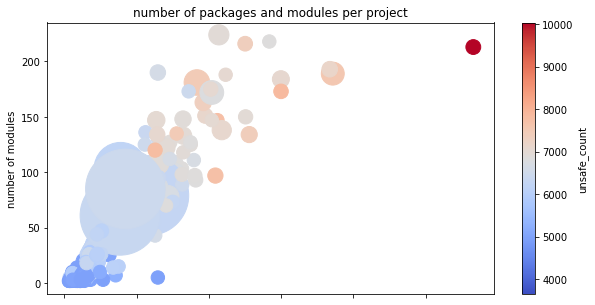

In [444]:
df1 = package_df\
    .groupby('project_name')['import_path'].nunique()

df2 = package_df\
    .groupby('project_name')['module_path'].nunique()

df3 = grep_df\
    .groupby('project_name')\
    .agg(unsafe_count=pd.NamedAgg(column='project_name', aggfunc='count'))

df4 = vet_df\
    .groupby('project_name')\
    .agg(vet_count=pd.NamedAgg(column='project_name', aggfunc='count'))

mdf1 = pd.merge(df1, df2, how='inner', on='project_name')
mdf2 = pd.merge(mdf1, df3, how='left', on='project_name')
mdf3 = pd.merge(mdf2, df4, how='left', on='project_name').fillna(0)

mdf3\
    .plot.scatter(x='import_path', y='module_path', c='unsafe_count', cmap="coolwarm", s=mdf3['vet_count'],
                  title='number of packages and modules per project',
                  figsize=(10,5))

plt.xlabel('number of packages')
plt.ylabel('number of modules')
plt.show()

Wir können sehen, dass die Projekte mit höherer unsafe Anzahl eher weniger Vet Ergebnisse haben.

## Prozentsatz von unsafe.Pointer nutzenden Modulen

In [76]:
total_modules_count = package_df['module_path'].nunique()
unsafe_modules_count = grep_df['module_path'].nunique()

In [73]:
print("{} of {} modules ({:.1%}) have at least one unsafe usage."\
      .format(unsafe_modules_count, total_modules_count, unsafe_modules_count/total_modules_count))

553 of 3119 modules (17.7%) have at least one unsafe usage.


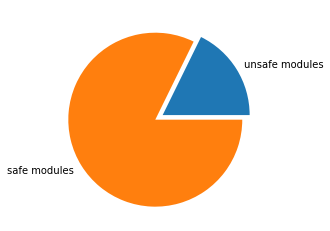

In [74]:
data = [unsafe_modules_count, total_modules_count - unsafe_modules_count]

plt.pie(data, labels=['unsafe modules', 'safe modules'], explode=(0, 0.1))

plt.show()

## Prozentsatz von unsafe.Pointer nutzenden Packages

In [77]:
total_packages_count = package_df['import_path'].nunique()
unsafe_packages_count = grep_df['package_import_path'].nunique()

In [78]:
print("{} of {} packages ({:.1%}) have at least one unsafe usage."\
      .format(unsafe_packages_count, total_packages_count, unsafe_packages_count/total_packages_count))

1179 of 37482 packages (3.1%) have at least one unsafe usage.


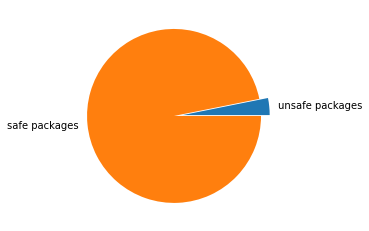

In [79]:
data = [unsafe_packages_count, total_packages_count - unsafe_packages_count]

plt.pie(data, labels=['unsafe packages', 'safe packages'], explode=(0, 0.1))

plt.show()

## Verteilung von unsafe auf verschiedene match types

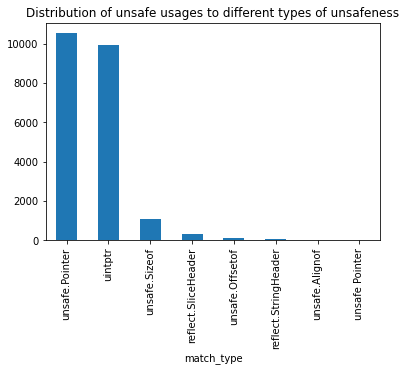

In [82]:
grep_df\
    .groupby(['match_type', 'package_import_path', 'project_name'])['match_type'].count()\
    .groupby(['match_type', 'package_import_path']).max()\
    .groupby('match_type').sum()\
    .sort_values(ascending=False)\
    .plot.bar(title='Distribution of unsafe usages to different types of unsafeness')

In [83]:
grep_df\
    .groupby(['match_type', 'package_import_path', 'project_name'])['match_type'].count()\
    .groupby(['match_type', 'package_import_path']).max()\
    .groupby('match_type').sum()\
    .sort_values(ascending=False)

match_type
unsafe.Pointer          10525
uintptr                  9926
unsafe.Sizeof            1109
reflect.SliceHeader       331
unsafe.Offsetof           146
reflect.StringHeader       93
unsafe.Alignof             34
unsafe Pointer              1
Name: match_type, dtype: int64

unsafe.Pointer und uintprt dominieren klar. Vermutlich werden sie fast immer gemeinsam genutzt. unsafe.Sizeof ist ebenfalls noch relativ häufig vertreten. Die anderen Typen sind im Vergleich extrem selten. Genau das könnte aber bedeuten, dass es Sinn macht sich diese manuell anzuschauen!

## Gleichzeitige Verwendung von uintptr und unsafe.Pointer pro Zeile

In [369]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = grep_df\
    .where(grep_df['match_type']=='uintptr').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

mdf = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'text_x', 'context_x', 'text_y', 'context_y', 
            'match_type_x', 'match_type_y']]

simultaneous_usages_df = mdf.dropna()
uintptr_without_unsafePointer_df = mdf.loc[mdf['match_type_x'].isnull()]
unsafePointer_without_uintptr_df = mdf.loc[mdf['match_type_y'].isnull()]

In [370]:
print("Number of unsafe.Pointer lines: {}".format(df1['line_number'].count()))
print("Number of uintptr lines: {}".format(df2['line_number'].count()))
print()
print("Number of simultaneous usages: {}".format(simultaneous_usages_df['line_number'].count()))
print("unsafe.Pointer used without uintptr: {}".format(unsafePointer_without_uintptr_df['line_number'].count()))
print("uintptr used without unsafe.Pointer: {}".format(uintptr_without_unsafePointer_df['line_number'].count()))

Number of unsafe.Pointer lines: 12286
Number of uintptr lines: 11273

Number of simultaneous usages: 2679
unsafe.Pointer used without uintptr: 9607
uintptr used without unsafe.Pointer: 8594


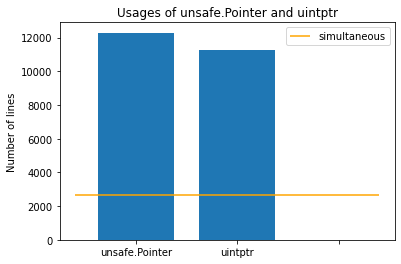

In [393]:
total_data = [df1['line_number'].count(), df2['line_number'].count(), 0]
idx = np.arange(3)/3

simultaneous_usages_df['line_number'].count()

plt.hlines(simultaneous_usages_df['line_number'].count(), -0.2, 0.8, colors='orange', label='simultaneous')
plt.bar(idx, total_data, width=0.25)

plt.ylabel('Number of lines')
plt.xticks(idx, ['unsafe.Pointer', 'uintptr', ''])
plt.legend()
plt.title('Usages of unsafe.Pointer and uintptr')

plt.show()

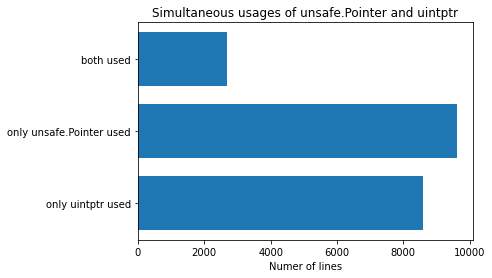

In [88]:
data = [uintptr_without_unsafePointer_df['line_number'].count(),
        unsafePointer_without_uintptr_df['line_number'].count(),
        simultaneous_usages_df['line_number'].count()]
idx = np.arange(3)/3
width = 0.25

plt.barh(idx, data, width)
plt.xlabel('Numer of lines')
plt.yticks(idx, ['only uintptr used', 'only unsafe.Pointer used', 'both used'])
plt.title('Simultaneous usages of unsafe.Pointer and uintptr')

plt.show()

In [91]:
print("simultaneous:")
print(simultaneous_usages_df['text_x'][11])

print("only unsafe.Pointer:")
print(unsafePointer_without_uintptr_df['text_x'].iloc[10])

print("only uintptr:")
print(uintptr_without_unsafePointer_df['text_y'].iloc[10])

simultaneous:
func abigen_runtime_memequal(a, b unsafe.Pointer, size uintptr) bool

only unsafe.Pointer:
	_cgo_yield                    unsafe.Pointer

only uintptr:
		wbBufFlush(slot, uintptr(new))



## Gleichzeitige Verwendung von uintptr und unsafe.Pointer pro Datei

In [515]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name'])

df2 = grep_df\
    .where(grep_df['match_type']=='uintptr').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name'])

mdf = pd.merge(df1, df2, how='left', on=['package_import_path', 'file_name'])\
    .loc[:,['package_import_path', 'file_name', 'line_number_x', 'line_number_y', 
            'text_x', 'context_x', 'text_y', 'context_y', 
            'match_type_x', 'match_type_y']]

same_file_usages_df = mdf.dropna()

In [517]:
print("Number of unsafe.Pointer files: {}".format(df1['line_number'].count()))
print("Number of uintptr files: {}".format(df2['line_number'].count()))
print()
print("Number of usages in the same file: {}".format(same_file_usages_df['line_number_x'].count()))

Number of unsafe.Pointer files: 1018
Number of uintptr files: 1098

Number of usages in the same file: 483


In [528]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = grep_df\
    .where(grep_df['match_type']=='uintptr').dropna()\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

unsafePointer_same_file_usages_df = pd.merge(df1, df2, how='left', on=['package_import_path', 'file_name'])\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number_x'])\
    .dropna()\
    .loc[:,['package_import_path', 'file_name', 'line_number_x', 'line_number_y', 
            'text_x', 'context_x', 'text_y', 'context_y', 
            'match_type_x', 'match_type_y']]

uintptr_same_file_usages_df = pd.merge(df1, df2, how='right', on=['package_import_path', 'file_name'])\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number_y'])\
    .dropna()\
    .loc[:,['package_import_path', 'file_name', 'line_number_x', 'line_number_y', 
            'text_x', 'context_x', 'text_y', 'context_y', 
            'match_type_x', 'match_type_y']]

In [529]:
print("Number of unsafe.Pointer lines: {}".format(df1['line_number'].count()))
print("Number of uintptr lines: {}".format(df2['line_number'].count()))
print()
print("Number of usages of unsafe.Pointer in files where at least one other uintptr occurs: {}"\
      .format(unsafePointer_same_file_usages_df['line_number_x'].count()))
print("Number of usages of uinttr in files where at least one other unsafe.Pointer occurs: {}"\
      .format(uintptr_same_file_usages_df['line_number_x'].count()))

Number of unsafe.Pointer lines: 12286
Number of uintptr lines: 11273

Number of usages of unsafe.Pointer in files where at least one other uintptr occurs: 6889
Number of usages of uinttr in files where at least one other unsafe.Pointer occurs: 6048


## Vet Ergebnisse pro Projekt

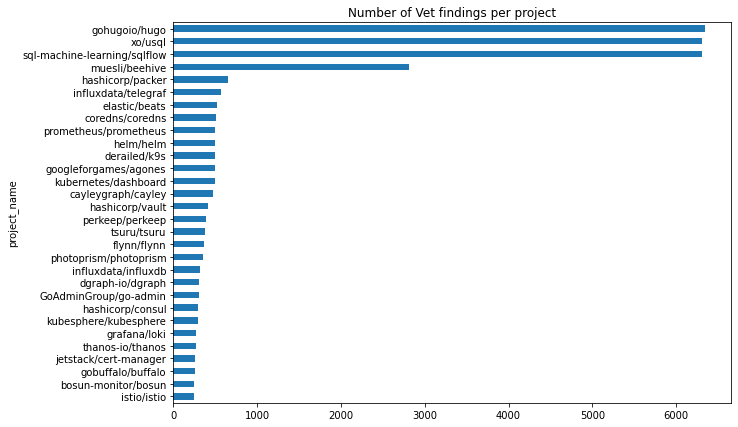

In [405]:
vet_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of Vet findings per project', figsize=(10,7))

In [403]:
vet_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=False)

project_name
gohugoio/hugo                   6344
xo/usql                         6311
sql-machine-learning/sqlflow    6309
muesli/beehive                  2813
hashicorp/packer                 654
                                ... 
golang/lint                      180
peco/peco                        180
panjf2000/ants                   179
hybridgroup/gocv                 179
buger/jsonparser                 179
Name: project_name, Length: 327, dtype: int64

In [408]:
vet_df[vet_df['project_name']=='kubernetes/kubernetes']

,message,context,line_number,column,raw_output,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
0,possible misuse of unsafe.Pointer,"\t\t\tif !CompareAndSwapPointer(&vp.typ, nil, ...",59,44,/usr/local/go/src/sync/atomic/value.go:59:44: ...,value.go,86,2446,sync/atomic,std,std,kubernetes/kubernetes,sync/atomic/value.go
1,possible misuse of unsafe.Pointer,\treturn unsafe.Pointer(x ^ 0),287,9,/root/go/pkg/mod/github.com/modern-go/reflect2...,reflect2.go,298,7272,github.com/modern-go/reflect2,github.com/modern-go/reflect2,v1.0.1,kubernetes/kubernetes,github.com/modern-go/reflect2/reflect2.go
2,possible misuse of unsafe.Pointer,\treturn unsafe.Pointer(x ^ 0),30,9,/usr/local/go/src/strings/builder.go:30:9: pos...,builder.go,125,3562,strings,std,std,kubernetes/kubernetes,strings/builder.go
3,possible misuse of unsafe.Pointer,\tsize := *(*uintptr)(unsafe.Pointer(ptr + uns...,56,22,/usr/local/go/src/runtime/alg.go:56:22: possib...,alg.go,389,10428,runtime,std,std,kubernetes/kubernetes,runtime/alg.go
4,possible misuse of unsafe.Pointer,\told := unsafe.Pointer(sync_atomic_SwapUintpt...,63,9,/usr/local/go/src/runtime/atomic_pointer.go:63...,atomic_pointer.go,77,2683,runtime,std,std,kubernetes/kubernetes,runtime/atomic_pointer.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,golang.org/x/text/encoding/internal.FuncEncodi...,"\tinternal.FuncEncoding{iso2022JPNewDecoder, i...",20,2,/root/go/pkg/mod/golang.org/x/text@v0.3.2/enco...,iso2022jp.go,299,6772,golang.org/x/text/encoding/japanese,golang.org/x/text,v0.3.2,kubernetes/kubernetes,golang.org/x/text/encoding/japanese/iso2022jp.go
279,golang.org/x/text/encoding/internal.Encoding c...,var shiftJIS = internal.Encoding{\n\t&internal...,20,16,/root/go/pkg/mod/golang.org/x/text@v0.3.2/enco...,shiftjis.go,189,4290,golang.org/x/text/encoding/japanese,golang.org/x/text,v0.3.2,kubernetes/kubernetes,golang.org/x/text/encoding/japanese/shiftjis.go
280,golang.org/x/text/encoding/internal.SimpleEnco...,"\t&internal.SimpleEncoding{shiftJISDecoder{}, ...",21,3,/root/go/pkg/mod/golang.org/x/text@v0.3.2/enco...,shiftjis.go,189,4290,golang.org/x/text/encoding/japanese,golang.org/x/text,v0.3.2,kubernetes/kubernetes,golang.org/x/text/encoding/japanese/shiftjis.go
281,unreachable code,"\treturn s, nil",770,2,/root/go/pkg/mod/github.com/magiconair/propert...,properties.go,833,22854,github.com/magiconair/properties,github.com/magiconair/properties,v1.8.1,kubernetes/kubernetes,github.com/magiconair/properties/properties.go


Kubernetes hat erstaunlich wenige Vet Ergebnisse. Hugo ist so weit vorne weil das `chroma` Modul eingebunden wird (siehe nächste Analyse).

## Vet Ergebnisse pro Modul

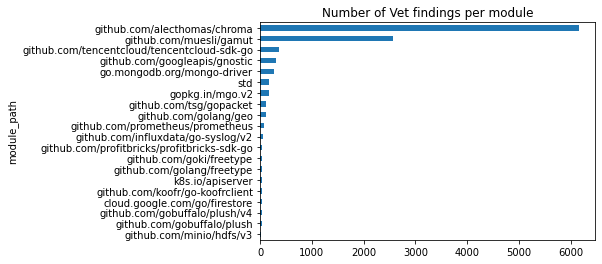

In [406]:
vet_df\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of Vet findings per module')

In [409]:
vet_df\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=False)[:20]

module_path
github.com/alecthomas/chroma                   6158
github.com/muesli/gamut                        2565
github.com/tencentcloud/tencentcloud-sdk-go     360
github.com/googleapis/gnostic                   308
go.mongodb.org/mongo-driver                     274
std                                             180
gopkg.in/mgo.v2                                 172
github.com/tsg/gopacket                         113
github.com/golang/geo                           112
github.com/prometheus/prometheus                 67
github.com/influxdata/go-syslog/v2               48
github.com/profitbricks/profitbricks-sdk-go      39
github.com/goki/freetype                         38
github.com/golang/freetype                       36
k8s.io/apiserver                                 36
github.com/koofr/go-koofrclient                  35
cloud.google.com/go/firestore                    30
github.com/gobuffalo/plush/v4                    29
github.com/gobuffalo/plush                       29


Interessanterweise sind die beiden ersten, mit deutlichem Abstand führenden Module, mit Farben beschäftigt. Was geht mit diesen Farben ab?

## Vet Ergebnisse pro Package

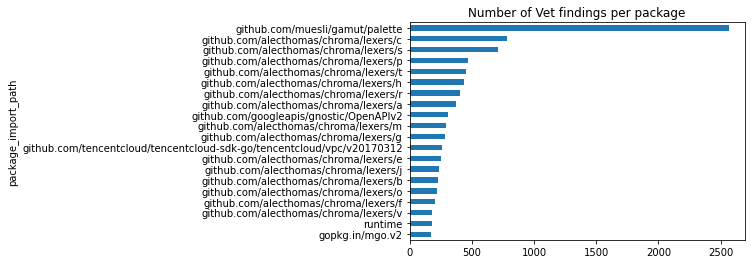

In [411]:
vet_df\
    .groupby(['package_import_path', 'project_name'])['package_import_path'].count()\
    .groupby('package_import_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of Vet findings per package')

In [410]:
vet_df\
    .groupby(['package_import_path', 'project_name'])['package_import_path'].count()\
    .groupby('package_import_path').max()\
    .sort_values(ascending=False)[:20]

package_import_path
github.com/muesli/gamut/palette                                           2565
github.com/alecthomas/chroma/lexers/c                                      779
github.com/alecthomas/chroma/lexers/s                                      712
github.com/alecthomas/chroma/lexers/p                                      468
github.com/alecthomas/chroma/lexers/t                                      449
github.com/alecthomas/chroma/lexers/h                                      440
github.com/alecthomas/chroma/lexers/r                                      408
github.com/alecthomas/chroma/lexers/a                                      369
github.com/googleapis/gnostic/OpenAPIv2                                    308
github.com/alecthomas/chroma/lexers/m                                      288
github.com/alecthomas/chroma/lexers/g                                      287
github.com/tencentcloud/tencentcloud-sdk-go/tencentcloud/vpc/v20170312     258
github.com/alecthomas/chroma/lex

## Vet Ergebnisse im Zusammenhang mit unsafe

In [414]:
df1 = grep_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = vet_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

mdf = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'text', 'context_x', 'match_type', 'message']]

vet_and_unsafe_df = mdf.dropna()
only_vet_df = mdf.loc[mdf['text'].isnull()]
only_unsafe_df = mdf.loc[mdf['message'].isnull()]

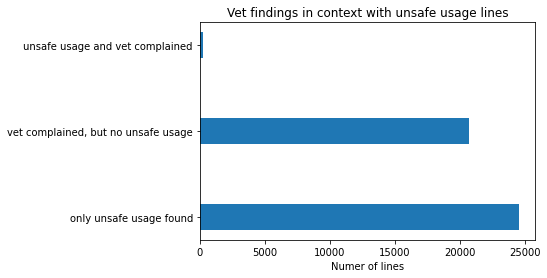

In [415]:
data = [only_unsafe_df['line_number'].count(),
        only_vet_df['line_number'].count(),
        vet_and_unsafe_df['line_number'].count()]
idx = np.arange(3)/3
width = 0.1

plt.barh(idx, data, width)
plt.xlabel('Numer of lines')
plt.yticks(idx, ['only unsafe usage found', 'vet complained, but no unsafe usage', 'unsafe usage and vet complained'])
plt.title('Vet findings in context with unsafe usage lines')

plt.show()

## Anzahl unsafe.Pointer usages, die von Vet erkannt wurden

In [460]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = vet_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'message']]

vet_unsafePointer_df = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .dropna()\
    .loc[:,['project_name', 'module_path', 'module_version', 'package_import_path', 'match_type', 
            'file_name', 'line_number', 'text', 'context', 'message']]

In [461]:
print("Number of lines with unsafe.Pointer usage that were flagged by vet: {}"\
      .format(vet_unsafePointer_df['message'].count()))
print()
print("Vet messages on these lines:")
print(vet_unsafePointer_df['message'].sort_values())

Number of lines with unsafe.Pointer usage that were flagged by vet: 211

Vet messages on these lines:
21       possible misuse of unsafe.Pointer
992      possible misuse of unsafe.Pointer
993      possible misuse of unsafe.Pointer
1006     possible misuse of unsafe.Pointer
1007     possible misuse of unsafe.Pointer
                       ...                
627      possible misuse of unsafe.Pointer
628      possible misuse of unsafe.Pointer
629      possible misuse of unsafe.Pointer
493      possible misuse of unsafe.Pointer
13839    possible misuse of unsafe.Pointer
Name: message, Length: 211, dtype: object


Wir sehen hier, dass alle Zeilen mit Vet Ergebnis und Grep Ergebnis tatsächlich die Nachricht `possible misuse of unsafe.Pointer` zeigen. Diese sind also definitiv näher zu betrachten.

In [462]:
vet_unsafePointer_df.to_csv('/root/data/interesting_snippets_vet_unsafePointer.csv', index=False)

## Gosec Ergebnisse pro Projekt

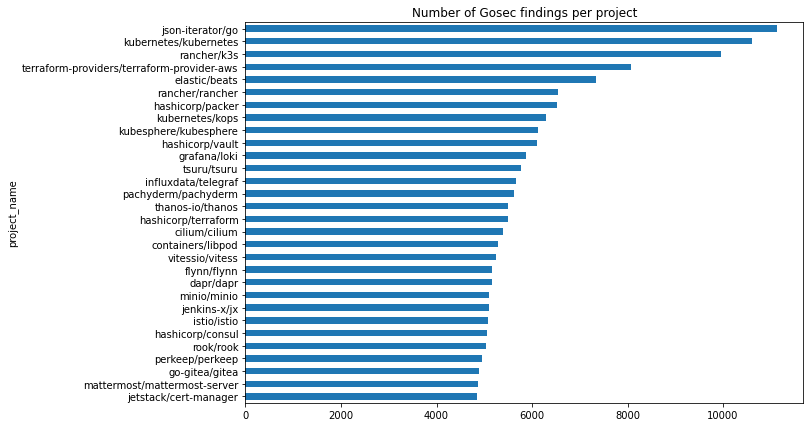

In [464]:
gosec_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=True)[-30:]\
    .plot.barh(title='Number of Gosec findings per project', figsize=(10,7))

In [465]:
gosec_df\
    .groupby('project_name')['project_name'].count()\
    .sort_values(ascending=False)

project_name
json-iterator/go                              11128
kubernetes/kubernetes                         10607
rancher/k3s                                    9964
terraform-providers/terraform-provider-aws     8080
elastic/beats                                  7347
                                              ...  
yeasy/docker_practice                          1531
astaxie/go-best-practice                       1531
tmrts/go-patterns                              1531
andlabs/ui                                     1357
jroimartin/gocui                               1110
Name: project_name, Length: 495, dtype: int64

## Gosec Ergebnisse pro Modul

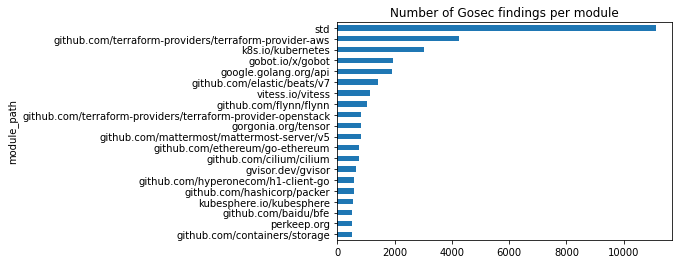

In [466]:
gosec_df\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of Gosec findings per module')

In [467]:
gosec_df\
    .groupby(['module_path', 'project_name'])['module_path'].count()\
    .groupby('module_path').max()\
    .sort_values(ascending=False)[:20]

module_path
std                                                            11128
github.com/terraform-providers/terraform-provider-aws           4237
k8s.io/kubernetes                                               3019
gobot.io/x/gobot                                                1954
google.golang.org/api                                           1909
github.com/elastic/beats/v7                                     1440
vitess.io/vitess                                                1151
github.com/flynn/flynn                                          1040
github.com/terraform-providers/terraform-provider-openstack      838
gorgonia.org/tensor                                              826
github.com/mattermost/mattermost-server/v5                       824
github.com/ethereum/go-ethereum                                  764
github.com/cilium/cilium                                         760
gvisor.dev/gvisor                                                658
github.com/hyperonecom

## Gosec Ergebnisse pro Package

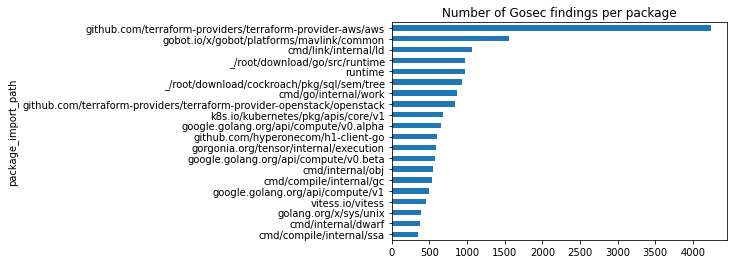

In [469]:
gosec_df\
    .groupby(['package_import_path', 'project_name'])['package_import_path'].count()\
    .groupby('package_import_path').max()\
    .sort_values(ascending=True)[-20:]\
    .plot.barh(title='Number of Gosec findings per package')

In [470]:
gosec_df\
    .groupby(['package_import_path', 'project_name'])['package_import_path'].count()\
    .groupby('package_import_path').max()\
    .sort_values(ascending=False)[:20]

package_import_path
github.com/terraform-providers/terraform-provider-aws/aws                4237
gobot.io/x/gobot/platforms/mavlink/common                                1553
cmd/link/internal/ld                                                     1068
_/root/download/go/src/runtime                                            975
runtime                                                                   972
_/root/download/cockroach/pkg/sql/sem/tree                                935
cmd/go/internal/work                                                      864
github.com/terraform-providers/terraform-provider-openstack/openstack     838
k8s.io/kubernetes/pkg/apis/core/v1                                        676
google.golang.org/api/compute/v0.alpha                                    651
github.com/hyperonecom/h1-client-go                                       598
gorgonia.org/tensor/internal/execution                                    581
google.golang.org/api/compute/v0.beta       

## Gosec Ergebnisse im Zusammenhang mit Unsafe

In [472]:
df1 = grep_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = gosec_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

mdf = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'text', 'context_x', 'match_type', 'message']]

gosec_and_unsafe_df = mdf.dropna()
only_gosec_df = mdf.loc[mdf['text'].isnull()]
only_unsafe_gosec = mdf.loc[mdf['message'].isnull()]

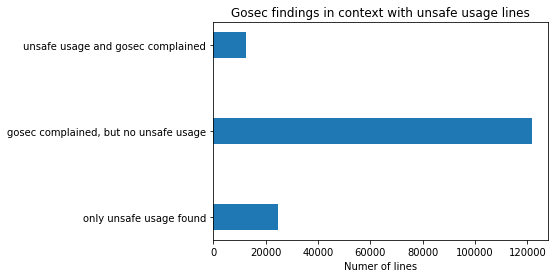

In [473]:
data = [only_unsafe_df['line_number'].count(),
        only_gosec_df['line_number'].count(),
        gosec_and_unsafe_df['line_number'].count()]
idx = np.arange(3)/3
width = 0.1

plt.barh(idx, data, width)
plt.xlabel('Numer of lines')
plt.yticks(idx, ['only unsafe usage found', 'gosec complained, but no unsafe usage', 'unsafe usage and gosec complained'])
plt.title('Gosec findings in context with unsafe usage lines')

plt.show()

## unsafe.Pointer usages, die von Gosec erkannt wurden

In [474]:
df1 = grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

df2 = gosec_df\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])\
    .loc[:,['package_import_path', 'file_name', 'line_number', 'message']]

gosec_unsafePointer_df = pd.merge(df1, df2, how='outer', on=['package_import_path', 'file_name', 'line_number'])\
    .dropna()\
    .loc[:,['project_name', 'module_path', 'module_version', 'package_import_path', 'match_type', 
            'file_name', 'line_number', 'text', 'context', 'message']]

In [476]:
print("Number of lines with unsafe.Pointer usage that were flagged by gosec: {}"\
      .format(gosec_unsafePointer_df['message'].count()))
print()
print("Gosec messages on these lines:")

gosec_unsafePointer_df\
    .groupby('message')['message'].count()

Number of lines with unsafe.Pointer usage that were flagged by gosec: 8354

Gosec messages on these lines:


message
Errors unhandled.                          21
Use of unsafe calls should be audited    8333
Name: message, dtype: int64

Ein erstaunliches Ergebnis, denn die unsafe Regel in Gosec prüft eigentlich ausschließlich, ob unsafe.Pointer überhaupt verwendet wird. Das heißt es sollten eigentlich alle Zeilen, in denen ich mit Grep unsafe.Pointer gefunden habe, auch von Gosec gefunden werden. Das ist offensichtlich (zahlenmäßig) nicht der Fall:

In [477]:
grep_df\
    .where(grep_df['match_type']=='unsafe.Pointer')\
    .drop_duplicates(subset=['line_number', 'file_name', 'package_import_path'])\
    ['line_number'].count()

14050

Allerdings werden offenbar zumindest ca. die Hälfte der Fälle erkannt. Speichern der Fälle, um sie manuell zu clustern:

In [478]:
gosec_unsafePointer_df.to_csv('/root/data/interesting_snippets_gosec_unsafePointer.csv')

## Verteilung unsafe.Pointer usage auf Stars/Forks/LastPushAge

In [361]:
df1 = grep_df\
    .groupby('project_name')\
    .agg(unsafe_count=pd.NamedAgg(column='project_name', aggfunc='count'))

df2 = projects_df

unsafe_by_project_features_df = pd.merge(df1, df2, how='left', on=['project_name'])

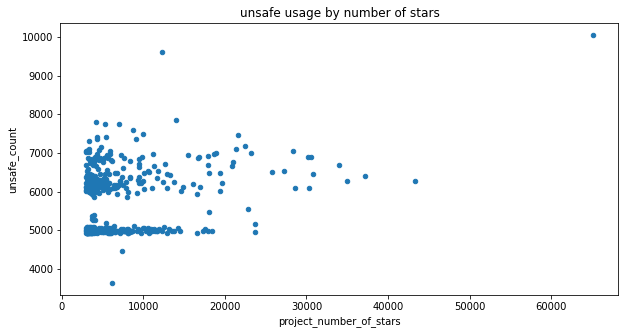

In [362]:
unsafe_by_project_features_df\
    .plot.scatter(x='project_number_of_stars', y='unsafe_count',
                  title='unsafe usage by number of stars', 
                  figsize=(10,5))

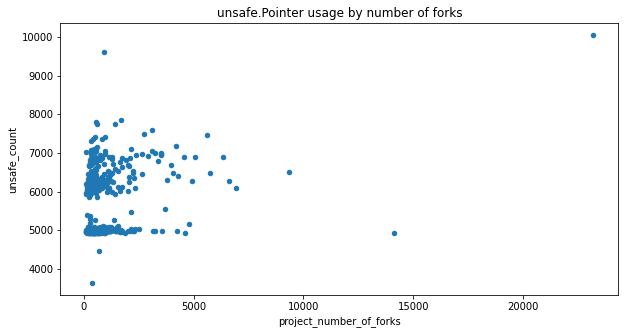

In [364]:
unsafe_by_project_features_df\
    .plot.scatter(x='project_number_of_forks', y='unsafe_count',
                  title='unsafe.Pointer usage by number of forks', 
                  figsize=(10,5))

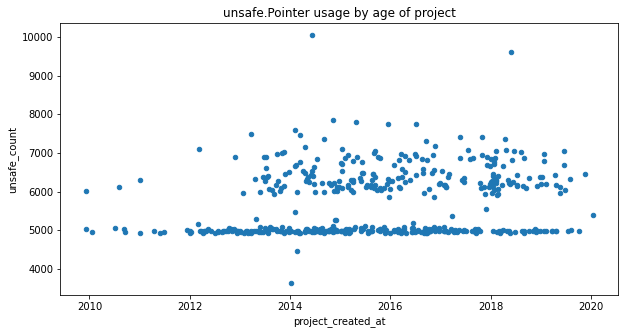

In [365]:
unsafe_by_project_features_df\
    .plot.scatter(x='project_created_at', y='unsafe_count',
                  title='unsafe.Pointer usage by age of project', 
                  figsize=(10,5))

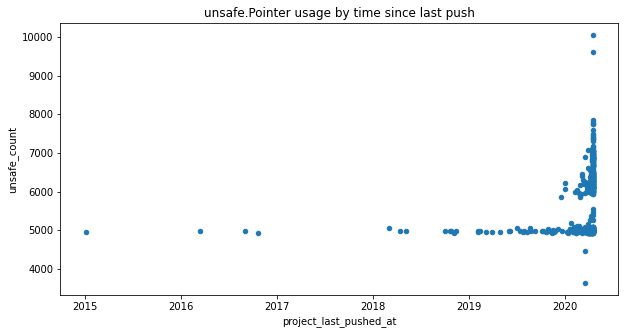

In [366]:
unsafe_by_project_features_df\
    .plot.scatter(x='project_last_pushed_at', y='unsafe_count',
                  title='unsafe.Pointer usage by time since last push',
                  figsize=(10,5))

## unsafe usage pro Modul, gewichtet nach Modulbeliebtheit

In [231]:
df1 = grep_df\
    .groupby(['module_path', 'project_name'])\
    .agg(unsafe_count=pd.NamedAgg(column='module_path', aggfunc='count'))\
    .groupby('module_path').max()\
    .reset_index()

df2 = package_df\
    .groupby('module_path')\
    .agg(import_count=pd.NamedAgg(column='project_name', aggfunc='nunique'))\
    .reset_index()

unsafe_modules_weighted_popularity_df = pd.merge(df1, df2, how='inner', on=['module_path'])

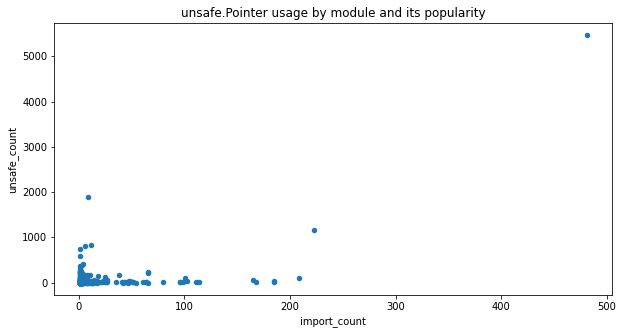

In [204]:
unsafe_modules_weighted_popularity_df\
    .plot.scatter(x='import_count', y='unsafe_count', 
                  title='unsafe.Pointer usage by module and its popularity',
                  figsize=(10,5))

Offensichtlich wäre der interessanteste Punkt das Modul ganz oben rechts. Das ist allerdings die Standardlibrary. Hat sie besseren Code als andere Module?

Analyse ohne die Standardlibrary:

In [320]:
df1 = grep_df\
    .where(grep_df['module_path']!='std')\
    .groupby(['module_path', 'project_name'])\
    .agg(unsafe_count=pd.NamedAgg(column='module_path', aggfunc='count'))\
    .groupby('module_path').max()

df2 = package_df\
    .groupby('module_path')\
    .agg(import_count=pd.NamedAgg(column='project_name', aggfunc='nunique'))

df = pd.merge(df1, df2, how='left', on=['module_path'])

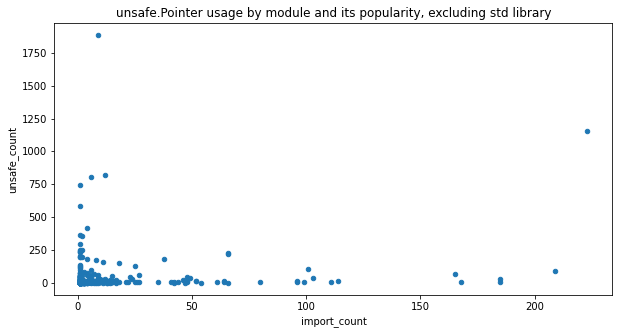

In [321]:
df.plot.scatter(x='import_count', y='unsafe_count', 
                title='unsafe.Pointer usage by module and its popularity, excluding std library',
                figsize=(10,5))

## unsafe Usages und LOC pro Modul

In [316]:
df1 = grep_df\
    .where(grep_df['module_path']!='std')\
    .groupby(['module_path', 'project_name'])\
    .agg(unsafe_count=pd.NamedAgg(column='module_path', aggfunc='count'))\
    .groupby('module_path').max()\
    .reset_index()

df2 = package_df\
    .where(grep_df['module_path']!='std')\
    .groupby('module_path')\
    .agg(loc=pd.NamedAgg(column='loc', aggfunc='sum'))\
    .reset_index()

df = pd.merge(df1, df2, how='inner', on=['module_path'])

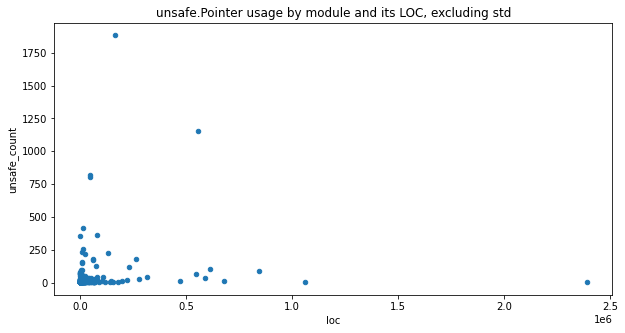

In [317]:
df.plot.scatter(x='loc', y='unsafe_count', 
                title='unsafe.Pointer usage by module and its LOC, excluding std',
                figsize=(10,5))

## Interessanteste Module gemäß Score aus Anzahl unsafe und Beliebtheit

In [236]:
weighted_df = unsafe_modules_weighted_popularity_df.reset_index()

weighted_df['score'] = weighted_df[['unsafe_count', 'import_count']]\
    .apply(lambda x: x['unsafe_count'] * x['import_count'], axis=1)

weighted_df\
    .sort_values(by='score', ascending=False)[:20]

,index,module_path,unsafe_count,import_count,score
550,550,std,5460,481,2626260
488,488,golang.org/x/sys,1154,223,257342
486,486,golang.org/x/net,91,209,19019
533,533,k8s.io/kubernetes,1883,9,16947
270,270,github.com/json-iterator/go,225,66,14850
320,320,github.com/modern-go/reflect2,215,66,14190
211,211,github.com/golang/protobuf,65,165,10725
208,208,github.com/gogo/protobuf,103,101,10403
433,433,github.com/ugorji/go/codec,823,12,9876
490,490,golang.org/x/tools,178,38,6764


Nach der Standardlibrary und dem `sys` Paket scheinen vor allem diese Module interessant zu sein:

 - k8s.io/kubernetes weil es sehr viele unsafe.Pointer usages hat
 - github.com/json-iterator/go weil es vergleichsweise häufig importiert wird und unsafe.Pointer usages hat
 - github.com/modern-go/reflect2	 weil es vergleichsweise häufig importiert wird, unsafe.Pointer usages hat und nicht von golang.org ist
 - github.com/golang/protobuf aus dem gleichen Grund

## Top 10 häufigste unsafe.Pointer Snippets

In [205]:
usages = grep_df\
    .groupby(['text'])\
    .agg(count=pd.NamedAgg(column='text', aggfunc='count')).reset_index()\
    .sort_values(by='count', ascending=False)[:10]

for i, usage in usages.iterrows():
    print("{} usages:".format(usage['count']))
    print(usage['text'])

13444 usages:
		_p0 = unsafe.Pointer(&_zero)

13444 usages:
	var _p0 unsafe.Pointer

12009 usages:
		return &(*u)(unsafe.Pointer(t)).u

8658 usages:
	b := (*bmap)(unsafe.Pointer(uintptr(h.buckets) + bucket*uintptr(t.bucketsize)))

6318 usages:
	_, _, e1 := Syscall6(SYS_MOUNT, uintptr(unsafe.Pointer(_p0)), uintptr(unsafe.Pointer(_p1)), uintptr(unsafe.Pointer(_p2)), uintptr(flags), uintptr(unsafe.Pointer(data)), 0)

5772 usages:
	hash := t.hasher(noescape(unsafe.Pointer(&key)), uintptr(h.hash0))

5616 usages:
	r0, _, e1 := Syscall6(SYS_RECVFROM, uintptr(fd), uintptr(_p0), uintptr(len(p)), uintptr(flags), uintptr(unsafe.Pointer(from)), uintptr(unsafe.Pointer(fromlen)))

5616 usages:
	r0, _, e1 := Syscall6(SYS_SPLICE, uintptr(rfd), uintptr(unsafe.Pointer(roff)), uintptr(wfd), uintptr(unsafe.Pointer(woff)), uintptr(len), uintptr(flags))

4914 usages:
	_, _, e1 := Syscall6(SYS_SETXATTR, uintptr(unsafe.Pointer(_p0)), uintptr(unsafe.Pointer(_p1)), uintptr(_p2), uintptr(len(data)), uintptr(flag

## Top 350 interessanteste unsafe.Pointer Snippets

In [252]:
weighted_df.sort_values(by='import_count', ascending=False)[:20]

,index,module_path,unsafe_count,import_count,score
550,550,std,5460,481,2626260
488,488,golang.org/x/sys,1154,223,257342
486,486,golang.org/x/net,91,209,19019
484,484,golang.org/x/crypto,28,185,5180
489,489,golang.org/x/text,2,185,370
362,362,github.com/pkg/errors,6,168,1008
211,211,github.com/golang/protobuf,65,165,10725
496,496,google.golang.org/grpc,13,114,1482
304,304,github.com/mattn/go-isatty,4,111,444
132,132,github.com/davecgh/go-spew,38,103,3914


In [307]:
interesting_snippets_df = grep_df\
    .where((grep_df['module_path']=='golang.org/x/net') | 
           (grep_df['module_path']=='golang.org/x/crypto') |
           (grep_df['module_path']=='github.com/golang/protobuf') |
           (grep_df['module_path']=='github.com/json-iterator/go'))\
    .drop_duplicates(subset=['text'])\
    .dropna()

Die Anzahl der einzelnen Posten stimmt nicht mit der Tabelle oben überein, weil dort Duplikate nicht gedroppt werden.

In [308]:
interesting_snippets_df

,text,context,line_number,column,absolute_offset,match_type,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
5122,\treturn *(*string)(unsafe.Pointer(&any.buf))\n,\treturn 0\n}\n\nfunc (any *arrayLazyAny) ToSt...,90.0,19.0,1236.0,unsafe.Pointer,any_array.go,4838.0,278.0,github.com/json-iterator/go,github.com/json-iterator/go,v1.1.8,kubernetes/kubernetes,github.com/json-iterator/go/any_array.go
5123,\t\t\treturn WrapUint32(uint32(val.(uintptr)))\n,\t\t}\n\t\treturn WrapUint64(uint64(val.(uint)...,124.0,33.0,2591.0,uintptr,any.go,7195.0,325.0,github.com/json-iterator/go,github.com/json-iterator/go,v1.1.8,kubernetes/kubernetes,github.com/json-iterator/go/any.go
5124,\t\treturn WrapUint64(uint64(val.(uintptr)))\n,\tcase reflect.Uintptr:\n\t\tif ptrSize == 32 ...,126.0,32.0,2639.0,uintptr,any.go,7195.0,325.0,github.com/json-iterator/go,github.com/json-iterator/go,v1.1.8,kubernetes/kubernetes,github.com/json-iterator/go/any.go
5125,func (codec *anyCodec) Decode(ptr unsafe.Point...,type anyCodec struct {\n\tvalType reflect2.Typ...,290.0,34.0,6382.0,unsafe.Pointer,any.go,7195.0,325.0,github.com/json-iterator/go,github.com/json-iterator/go,v1.1.8,kubernetes/kubernetes,github.com/json-iterator/go/any.go
5126,func (codec *anyCodec) Encode(ptr unsafe.Point...,func (codec *anyCodec) Decode(ptr unsafe.Point...,294.0,34.0,6479.0,unsafe.Pointer,any.go,7195.0,325.0,github.com/json-iterator/go,github.com/json-iterator/go,v1.1.8,kubernetes/kubernetes,github.com/json-iterator/go/any.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360950,func (decoder *fuzzyStringDecoder) Decode(ptr ...,\ntype fuzzyStringDecoder struct {\n}\n\nfunc ...,177.0,46.0,5404.0,unsafe.Pointer,fuzzy_decoder.go,8492.0,294.0,github.com/json-iterator/go/extra,github.com/json-iterator/go,v1.1.8,windmilleng/tilt,github.com/json-iterator/go/extra/fuzzy_decode...
2360951,"\tfun func(isFloat bool, ptr unsafe.Pointer, i...",\t}\n}\n\ntype fuzzyIntegerDecoder struct {\n\...,195.0,28.0,5906.0,unsafe.Pointer,fuzzy_decoder.go,8492.0,294.0,github.com/json-iterator/go/extra,github.com/json-iterator/go,v1.1.8,windmilleng/tilt,github.com/json-iterator/go/extra/fuzzy_decode...
2360952,func (decoder *fuzzyIntegerDecoder) Decode(ptr...,type fuzzyIntegerDecoder struct {\n\tfun func(...,198.0,47.0,5978.0,unsafe.Pointer,fuzzy_decoder.go,8492.0,294.0,github.com/json-iterator/go/extra,github.com/json-iterator/go,v1.1.8,windmilleng/tilt,github.com/json-iterator/go/extra/fuzzy_decode...
2360953,func (decoder *fuzzyFloat32Decoder) Decode(ptr...,\ntype fuzzyFloat32Decoder struct {\n}\n\nfunc...,235.0,47.0,6848.0,unsafe.Pointer,fuzzy_decoder.go,8492.0,294.0,github.com/json-iterator/go/extra,github.com/json-iterator/go,v1.1.8,windmilleng/tilt,github.com/json-iterator/go/extra/fuzzy_decode...


**save the interesting snippets for interop with classification tool**

In [479]:
interesting_snippets_df.to_csv('/root/data/interesting_snippets_popularity.csv', index=False)

**inspect interesting snippets**

In [311]:
interesting_snippets_df['text'][:10]

5122      \treturn *(*string)(unsafe.Pointer(&any.buf))\n
5123     \t\t\treturn WrapUint32(uint32(val.(uintptr)))\n
5124       \t\treturn WrapUint64(uint64(val.(uintptr)))\n
5125    func (codec *anyCodec) Decode(ptr unsafe.Point...
5126    func (codec *anyCodec) Encode(ptr unsafe.Point...
5127    func (codec *anyCodec) IsEmpty(ptr unsafe.Poin...
5128    func (codec *directAnyCodec) Decode(ptr unsafe...
5129    func (codec *directAnyCodec) Encode(ptr unsafe...
5130    func (codec *directAnyCodec) IsEmpty(ptr unsaf...
5133          \treturn *(*string)(unsafe.Pointer(&str))\n
Name: text, dtype: object

## Classifcation Labels

I define the following labels:

 - `uintptr_type`: uintptr is given a new name by assigning the type to a new named type
 - `function_call`: unsafe.Pointer is used for argument conversion when calling a function
 - `cast`: unsafe.Pointer is used for arbitrary type casting
 - `protocol`: unsafe usages are needed for byte-level exact network protocol handling
 - some more in the classification tool

## Manuelle Analyse von reflect.SliceHeader

In [484]:
slice_header_df = grep_df\
    .where(grep_df['match_type']=='reflect.SliceHeader')\
    .dropna()\
    .drop_duplicates(subset=['line_number', 'file_name', 'package_import_path'])

In [485]:
slice_header_df

,text,context,line_number,column,absolute_offset,match_type,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
343,// (6) Conversion of a reflect.SliceHeader or ...,//\t// before conversion back to Pointer.\n//\...,153.0,23.0,6463.0,reflect.SliceHeader,unsafe.go,9215.0,205.0,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
351,"// In general, reflect.SliceHeader and reflect...",//\n// In this usage hdr.Data is really an alt...,169.0,15.0,7252.0,reflect.SliceHeader,unsafe.go,9215.0,205.0,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
353,// only as *reflect.SliceHeader and *reflect.S...,// In this usage hdr.Data is really an alterna...,170.0,12.0,7327.0,reflect.SliceHeader,unsafe.go,9215.0,205.0,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
4345,\tsliceHeader := &reflect.SliceHeader{\n,}\n\nfunc UnsafeCastString(str string) []byte ...,292.0,17.0,7104.0,reflect.SliceHeader,reflect2.go,7272.0,298.0,github.com/modern-go/reflect2,github.com/modern-go/reflect2,v1.0.1,kubernetes/kubernetes,github.com/modern-go/reflect2/reflect2.go
6629,\th := (*reflect.SliceHeader)(unsafe.Pointer(&...,// Warning: the string returned by the functio...,21.0,8.0,616.0,reflect.SliceHeader,bytestostr.go,768.0,24.0,github.com/mailru/easyjson/jlexer,github.com/mailru/easyjson,v0.7.0,kubernetes/kubernetes,github.com/mailru/easyjson/jlexer/bytestostr.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725590,\tstringHeader.Data = (*reflect.SliceHeader)(u...,\n\t// NB(r): This makes sure that even if GC ...,74.0,23.0,3364.0,reflect.SliceHeader,bytes.go,3703.0,83.0,_/root/download/m3/src/x/unsafe,std,std,m3db/m3,_/root/download/m3/src/x/unsafe/bytes.go
2725593,\tbyteHeader := (*reflect.SliceHeader)(unsafe....,\t// once the slice's array pointer is updated...,73.0,17.0,3296.0,reflect.SliceHeader,string.go,4006.0,89.0,_/root/download/m3/src/x/unsafe,std,std,m3db/m3,_/root/download/m3/src/x/unsafe/string.go
2737300,\ttempSlice := *(*[]byte)(unsafe.Pointer(&refl...,"\t}\n}\n\nfunc newMemSwap(size uintptr, baseMe...",83.0,41.0,1999.0,reflect.SliceHeader,slice.go,4698.0,186.0,github.com/bradfitz/slice,github.com/bradfitz/slice,v0.0.0-20140430145140-a665b5dbaad5,bosun-monitor/bosun,github.com/bradfitz/slice/slice.go
2737303,\t\timem: *(*[]byte)(unsafe.Pointer(&reflect.S...,"\t\tLen: int(size),\n\t\tCap: int(size),\n\t...",89.0,35.0,2147.0,reflect.SliceHeader,slice.go,4698.0,186.0,github.com/bradfitz/slice,github.com/bradfitz/slice,v0.0.0-20140430145140-a665b5dbaad5,bosun-monitor/bosun,github.com/bradfitz/slice/slice.go


In [486]:
slice_header_df.to_csv('/root/data/interesting_snippets_sliceheader.csv', index=False)

## Wie oft kommt das uintptr(unsafe.Pointer(&ptr)) Pattern vor?

In [506]:
grep_df\
    [grep_df['text'].str.contains('uintptr\(unsafe.Pointer\(')]\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

,text,context,line_number,column,absolute_offset,match_type,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
105,\t\tsp := uintptr(unsafe.Pointer(&sig))\n,\t\tvar g *g\n\t\tif mainStarted {\n\t\t\tg = ...,46,8,1492,uintptr,cgo_sigaction.go,3164,87,runtime,std,std,kubernetes/kubernetes,runtime/cgo_sigaction.go
246,\tif inPersistentAlloc(uintptr(unsafe.Pointer(...,\n\t// It's OK if writing to memory allocated ...,49,22,1376,uintptr,cgocheck.go,6960,262,runtime,std,std,kubernetes/kubernetes,runtime/cgocheck.go
248,"\t\tprintln(""write of Go pointer"", hex(src), ""...",\t\treturn\n\t}\n\n\tsystemstack(func() {\n\t\...,54,67,1465,uintptr,cgocheck.go,6960,262,runtime,std,std,kubernetes/kubernetes,runtime/cgocheck.go
300,//\tf := unsafe.Pointer(uintptr(unsafe.Pointer...,// The most common use of this pattern is to a...,74,8,3034,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
305,//\te := unsafe.Pointer(uintptr(unsafe.Pointer...,//\t// equivalent to f := unsafe.Pointer(&s.f)...,77,8,3159,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731166,\t\t\t\t\tuintptr(unsafe.Pointer(&b.data[0])))\n,\t\t\t\tentry.keyStart = uint32(offset) + 2\n\...,1064,5,34821,uintptr,batch.go,44909,1458,github.com/cockroachdb/pebble,github.com/cockroachdb/pebble,v0.0.0-20200219202912-046831eaec09,lni/dragonboat,github.com/cockroachdb/pebble/batch.go
2731168,\tif uintptr(unsafe.Pointer(&inputs[0])) < uin...,\tfiles := c.version.Files[level]\n\t// Pointe...,314,4,11505,uintptr,compaction.go,62281,1823,github.com/cockroachdb/pebble,github.com/cockroachdb/pebble,v0.0.0-20200219202912-046831eaec09,lni/dragonboat,github.com/cockroachdb/pebble/compaction.go
2731172,\tstart := int((uintptr(unsafe.Pointer(&inputs...,\t// files. This is true for non-L0 files retu...,317,15,11626,uintptr,compaction.go,62281,1823,github.com/cockroachdb/pebble,github.com/cockroachdb/pebble,v0.0.0-20200219202912-046831eaec09,lni/dragonboat,github.com/cockroachdb/pebble/compaction.go
2731174,\t\tuintptr(unsafe.Pointer(&files[0]))) / unsa...,\tif uintptr(unsafe.Pointer(&inputs[0])) < uin...,318,2,11679,uintptr,compaction.go,62281,1823,github.com/cockroachdb/pebble,github.com/cockroachdb/pebble,v0.0.0-20200219202912-046831eaec09,lni/dragonboat,github.com/cockroachdb/pebble/compaction.go


In [507]:
grep_df\
    [grep_df['text'].str.contains('unsafe.Pointer\(uintptr\(')]\
    .drop_duplicates(subset=['package_import_path', 'file_name', 'line_number'])

,text,context,line_number,column,absolute_offset,match_type,file_name,file_loc,file_byte_size,package_import_path,module_path,module_version,project_name,file_copy_path
297,//\tp = unsafe.Pointer(uintptr(p) + offset)\n,"//\n// If p points into an allocated object, i...",68,7,2840,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
300,//\tf := unsafe.Pointer(uintptr(unsafe.Pointer...,// The most common use of this pattern is to a...,74,8,3034,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
305,//\te := unsafe.Pointer(uintptr(unsafe.Pointer...,//\t// equivalent to f := unsafe.Pointer(&s.f)...,77,8,3159,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
309,//\tend = unsafe.Pointer(uintptr(unsafe.Pointe...,// its original allocation:\n//\n//\t// INVALI...,88,9,3655,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
313,//\tend = unsafe.Pointer(uintptr(unsafe.Pointe...,//\tend = unsafe.Pointer(uintptr(unsafe.Pointe...,92,9,3805,unsafe.Pointer,unsafe.go,9215,205,unsafe,std,std,kubernetes/kubernetes,unsafe/unsafe.go
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737318,\tjp := (*unsafe.Pointer)(unsafe.Pointer(uintp...,"\nfunc (s *pointerSwap) Swap(i, j int) {\n\tba...",136,9,3360,unsafe.Pointer,slice.go,4698,186,github.com/bradfitz/slice,github.com/bradfitz/slice,v0.0.0-20140430145140-a665b5dbaad5,bosun-monitor/bosun,github.com/bradfitz/slice/slice.go
2737323,\tip := (*uint64)(unsafe.Pointer(uintptr(base)...,"}\n\nfunc (s *swap8) Swap(i, j int) {\n\tbase ...",148,17,3616,unsafe.Pointer,slice.go,4698,186,github.com/bradfitz/slice,github.com/bradfitz/slice,v0.0.0-20140430145140-a665b5dbaad5,bosun-monitor/bosun,github.com/bradfitz/slice/slice.go
2737326,\tjp := (*uint64)(unsafe.Pointer(uintptr(base)...,"\nfunc (s *swap8) Swap(i, j int) {\n\tbase := ...",149,17,3679,unsafe.Pointer,slice.go,4698,186,github.com/bradfitz/slice,github.com/bradfitz/slice,v0.0.0-20140430145140-a665b5dbaad5,bosun-monitor/bosun,github.com/bradfitz/slice/slice.go
2737330,\tip := (*uint32)(unsafe.Pointer(uintptr(base)...,"}\n\nfunc (s *swap4) Swap(i, j int) {\n\tbase ...",161,17,3921,unsafe.Pointer,slice.go,4698,186,github.com/bradfitz/slice,github.com/bradfitz/slice,v0.0.0-20140430145140-a665b5dbaad5,bosun-monitor/bosun,github.com/bradfitz/slice/slice.go


## Scratch Space

In [190]:
"It's dangerous to Go alone. Take *this!"

"It's dangerous to Go alone. Take *this!"